In [1]:
# Title: Analyze Dataset for Delay Causes using Spark (Multiple Files)

# Goal: Create a Google Colab notebook to load multiple dataset files,
# process them using Apache Spark, and identify the main causes of delay,
# along with other relevant delay patterns.

# Steps:

# 1. Setup:
# Install necessary libraries (findspark, pyspark).
!pip install findspark pyspark


In [2]:
# Initialize a Spark session.
import findspark
findspark.init()

# IMPORTANT: Ensure this cell with imports is run before any other cells that use these functions.
from pyspark.sql import SparkSession
# Import necessary functions from pyspark.sql.functions
from pyspark.sql.functions import sum, col, desc, coalesce, lit, count, avg, hour, dayofweek, when, month, substring, lpad # Ensure necessary functions are imported
import matplotlib.pyplot as plt
import pandas as pd
import os # Import os module to list files
from functools import reduce # Import reduce for summing columns - This import is essential for the reduce function.
                              # If you encounter a NameError for 'reduce', please ensure this cell is executed first.
from pyspark import SparkContext # Import SparkContext
# SparkContextState has been removed in newer pyspark versions.
# You likely don't need this import as SparkContext is already imported.
#from pyspark.context import SparkContextState # Import SparkContextState enumeration

In [3]:
# Create a SparkSession
# Check if a SparkSession already exists before creating a new one
spark = SparkSession.builder \
    .appName("FlightDelayAnalysisMultipleFiles") \
    .getOrCreate()

print("Spark session created successfully!")

# 2. Data Loading:
# Load the dataset from the specified path(s).
# Placeholder: Provide the path to your dataset directory or a list of file paths.
# If using a directory, Spark will read all files in that directory.
# Replace 'YOUR_DATASET_DIRECTORY' with the actual path to your directory containing CSV files.
# Or replace with a list like ['path/to/file1.csv', '/content/flight_data_part2.csv']
# NOTE: The months shown in the "Average Delay by Month" plot depend on the data files
# specified in 'file_paths'. Ensure your dataset includes data for all months you
# wish to analyze.
# file_paths = ['2024_01.csv', '2024_02.csv', '2024_03.csv', '2024_04.csv', '2024_05.csv', '2024_06.csv', '2024_07.csv']
file_paths = ['2024_01.csv']


Spark session created successfully!


In [4]:
# # Check if the Spark session is active before attempting to load data
# # Corrected check for stopped SparkContext using _jsc and isStopped()
# # This approach checks the underlying Java SparkContext status
# if spark.sparkContext._jsc is None or spark.sparkContext._jsc.sc().isStopped():
#     print("Error: SparkContext is stopped. Cannot load data. Please restart the Colab runtime.")
#     data_loaded = False
# else:
#     # Check if the path(s) exist and load data
#     data_loaded = False
#     if isinstance(file_paths, str):
#         # If file_paths is a string, check if the directory exists
#         if not os.path.exists(file_paths):
#             print(f"Error: The specified directory '{file_paths}' does not exist.")
#         else:
#             try:
#                 df = spark.read.csv(file_paths, header=True, inferSchema=True)
#                 print(f"Dataset(s) loaded from directory: {file_paths}")
#                 data_loaded = True
#             except Exception as e:
#                 print(f"An error occurred while reading data from directory {file_paths}: {e}")
#     elif isinstance(file_paths, list):
#         # If file_paths is a list, Spark can handle reading multiple files directly
#         # We can optionally check if each file exists, but Spark will error if not found during read
#         all_files_exist = True
#         for f_path in file_paths:
#             if not os.path.exists(f_path):
#                 print(f"Warning: File '{f_path}' does not exist.")
#                 all_files_exist = False # Or you might choose to break and not attempt reading

#         if all_files_exist and file_paths: # Ensure the list is not empty
#             try:
#                 df = spark.read.csv(file_paths, header=True, inferSchema=True)
#                 print(f"Dataset(s) loaded from list of files: {file_paths}")
#                 data_loaded = True
#             except Exception as e:
#                 print(f"An error occurred while reading data from list of files {file_paths}: {e}")
#         elif not file_paths:
#             print("Error: The list of file paths is empty.")
#     else:
#         print(f"Error: Invalid type for file_paths. Expected string or list, but got {type(file_paths)}")


# # Proceed with analysis only if data was loaded successfully
# if data_loaded:
#     # 3. Data Exploration and Preprocessing:
#     # Display the schema and a few rows of the DataFrame.
#     print("Dataset Schema:")
#     df.printSchema()

#     print("\nFirst 5 rows of the dataset:")
#     df.show(5)

#     # Handle missing values or incorrect data types in relevant columns.
#     # The delay columns are CarrierDelay, WeatherDelay, NASDelay, SecurityDelay, LateAircraftDelay.
#     # Coalesce null values in delay columns to 0, as null likely means no delay of that type.
#     delay_columns = ['CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay', 'ArrDelayMinutes']
#     for delay_col in delay_columns:
#         df = df.withColumn(delay_col, coalesce(col(delay_col), lit(0.0)))

#     # Ensure delay columns are numeric (inferSchema should handle this, but good practice to be aware)
#     # If schema inference fails, you might need to cast columns:
#     # from pyspark.sql.types import DoubleType
#     # for delay_col in delay_columns:
#     #     df = df.withColumn(delay_col, col(delay_col).cast(DoubleType()))

#     print("\nSchema after handling potential nulls in delay columns:")
#     df.printSchema()

#     # Add a total delay column for easier analysis
#     # Corrected: Summing multiple columns using Spark column expressions
#     # Use reduce with the addition operator to sum the columns
#     delay_cols_to_sum = [col(c) for c in delay_columns[:-1]] # Exclude ArrDelayMinutes from this sum
#     if delay_cols_to_sum: # Ensure the list is not empty
#         total_delay_expression = reduce(lambda x, y: x + y, delay_cols_to_sum)
#         df = df.withColumn("TotalDelayMinutes", total_delay_expression)
#     else:
#         # Handle case where there are no specific delay columns to sum
#         df = df.withColumn("TotalDelayMinutes", lit(0.0)) # Or handle as appropriate


#     # 4. Delay Analysis:

#     # Analysis 1: Total delay minutes by specific cause
#     print("\n--- Analysis 1: Total delay minutes by specific cause ---")
#     delay_cause_totals = df.agg(
#         sum("CarrierDelay").alias("CarrierDelay_Total"),
#         sum("WeatherDelay").alias("WeatherDelay_Total"),
#         sum("NASDelay").alias("NASDelay_Total"),
#         sum("SecurityDelay").alias("SecurityDelay_Total"),
#         sum("LateAircraftDelay").alias("LateAircraftDelay_Total")
#     )

#     print("Total delay minutes by cause:")
#     delay_cause_totals.show()

#     # Convert to Pandas for visualization and finding top causes
#     delay_totals_pd = delay_cause_totals.toPandas()
#     delay_totals_unpivoted = delay_totals_pd.melt(var_name='DelayCause', value_name='TotalDelayMinutes')
#     delay_totals_unpivoted['DelayCause'] = delay_totals_unpivoted['DelayCause'].str.replace('_Total', '')
#     top_causes_total = delay_totals_unpivoted.sort_values(by='TotalDelayMinutes', ascending=False)

#     N_causes = 5 # Number of top causes to display
#     print(f"\nTop {N_causes} Delay Causes (by total minutes):")
#     print(top_causes_total.head(min(N_causes, len(top_causes_total))))

#     # Visualization 1: Bar chart of total delay minutes by specific cause
#     plt.figure(figsize=(10, 6))
#     plt.bar(top_causes_total['DelayCause'], top_causes_total['TotalDelayMinutes'], color='skyblue')
#     plt.xlabel('Delay Cause')
#     plt.ylabel('Total Delay Minutes')
#     plt.title('Total Flight Delay Minutes by Specific Cause')
#     plt.xticks(rotation=45, ha='right')
#     plt.tight_layout()
#     plt.show()


#     # Analysis 2: Average arrival delay by Reporting Airline
#     print("\n--- Analysis 2: Average arrival delay by Reporting Airline ---")
#     avg_delay_by_airline = df.groupBy("Reporting_Airline").agg(
#         avg("ArrDelayMinutes").alias("AverageArrivalDelayMinutes"),
#         count("*").alias("NumberOfFlights")
#     ).orderBy(desc("AverageArrivalDelayMinutes"))

#     print("Average arrival delay by Reporting Airline:")
#     avg_delay_by_airline.show(10) # Show top 10 airlines by average delay

#     # Visualization 2: Bar chart of average arrival delay by Reporting Airline (Top 10)
#     avg_delay_airline_pd = avg_delay_by_airline.limit(10).toPandas()
#     plt.figure(figsize=(12, 7))
#     plt.bar(avg_delay_airline_pd['Reporting_Airline'], avg_delay_airline_pd['AverageArrivalDelayMinutes'], color='lightgreen')
#     plt.xlabel('Reporting Airline')
#     plt.ylabel('Average Arrival Delay (Minutes)')
#     plt.title('Top 10 Airlines by Average Arrival Delay')
#     plt.xticks(rotation=45, ha='right')
#     plt.tight_layout()
#     plt.show()

#     # Analysis 3: Average arrival delay by Origin Airport
#     print("\n--- Analysis 3: Average arrival delay by Origin Airport ---")
#     avg_delay_by_origin = df.groupBy("Origin").agg(
#         avg("ArrDelayMinutes").alias("AverageArrivalDelayMinutes"),
#         count("*").alias("NumberOfFlights")
#     ).orderBy(desc("AverageArrivalDelayMinutes"))

#     print("Average arrival delay by Origin Airport:")
#     avg_delay_by_origin.show(10) # Show top 10 origin airports by average delay

#     # Visualization 3: Bar chart of average arrival delay by Origin Airport (Top 10)
#     avg_delay_origin_pd = avg_delay_by_origin.limit(10).toPandas()
#     plt.figure(figsize=(12, 7))
#     plt.bar(avg_delay_origin_pd['Origin'], avg_delay_origin_pd['AverageArrivalDelayMinutes'], color='salmon')
#     plt.xlabel('Origin Airport')
#     plt.ylabel('Average Arrival Delay (Minutes)')
#     plt.title('Top 10 Origin Airports by Average Arrival Delay')
#     plt.xticks(rotation=45, ha='right')
#     plt.tight_layout()
#     plt.show()


#     # Analysis 4: Average arrival delay by Day of Week
#     print("\n--- Analysis 4: Average arrival delay by Day of Week ---")
#     # Map day of week number to name for better readability
#     avg_delay_by_dayofweek = df.groupBy("DayOfWeek").agg(
#         avg("ArrDelayMinutes").alias("AverageArrivalDelayMinutes"),
#         count("*").alias("NumberOfFlights")
#     ).orderBy("DayOfWeek") # Order by day number (1=Monday, 7=Sunday)

#     # Convert to Pandas to map day number to name and plot
#     avg_delay_dayofweek_pd = avg_delay_by_dayofweek.toPandas()
#     day_names = {1: 'Monday', 2: 'Tuesday', 3: 'Wednesday', 4: 'Thursday', 5: 'Friday', 6: 'Saturday', 7: 'Sunday'}
#     avg_delay_dayofweek_pd['DayOfWeek'] = avg_delay_dayofweek_pd['DayOfWeek'].map(day_names)

#     print("Average arrival delay by Day of Week:")
#     print(avg_delay_dayofweek_pd)

#     # Visualization 4: Bar chart of average arrival delay by Day of Week
#     plt.figure(figsize=(10, 6))
#     plt.bar(avg_delay_dayofweek_pd['DayOfWeek'], avg_delay_dayofweek_pd['AverageArrivalDelayMinutes'], color='gold')
#     plt.xlabel('Day of Week')
#     plt.ylabel('Average Arrival Delay (Minutes)')
#     plt.title('Average Arrival Delay by Day of Week')
#     plt.tight_layout()
#     plt.show()

#     # Analysis 5: Percentage contribution of each specific delay type to total delay
#     print("\n--- Analysis 5: Percentage contribution of each specific delay type ---")

#     total_sum_of_specific_delays = delay_cause_totals.agg(sum(col("CarrierDelay_Total") + col("WeatherDelay_Total") + col("NASDelay_Total") + col("SecurityDelay_Total") + col("LateAircraftDelay_Total"))).collect()[0][0]

#     if total_sum_of_specific_delays is not None and total_sum_of_specific_delays > 0:
#         delay_cause_percentages = delay_totals_unpivoted.copy()
#         delay_cause_percentages['Percentage'] = (delay_cause_percentages['TotalDelayMinutes'] / total_sum_of_specific_delays) * 100
#         delay_cause_percentages_sorted = delay_cause_percentages.sort_values(by='Percentage', ascending=False)

#         print("Percentage contribution of each specific delay type:")
#         print(delay_cause_percentages_sorted)

#         # Visualization 5: Pie chart of percentage contribution of specific delay types
#         plt.figure(figsize=(8, 8))
#         plt.pie(delay_cause_percentages_sorted['Percentage'], labels=delay_cause_percentages_sorted['DelayCause'], autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)
#         plt.title('Percentage Contribution of Specific Delay Types to Total Delay')
#         plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
#         plt.show()
#     else:
#         print("Total specific delay minutes is zero or None, cannot calculate percentages.")


#     # --- Additional Analyses and Visualizations ---

#     # Analysis 6: Average arrival delay by Time Block (ArrTimeBlk)
#     print("\n--- Analysis 6: Average arrival delay by Time Block ---")
#     avg_delay_by_time_blk = df.groupBy("ArrTimeBlk").agg(
#         avg("ArrDelayMinutes").alias("AverageArrivalDelayMinutes"),
#         count("*").alias("NumberOfFlights")
#     ).orderBy("ArrTimeBlk") # Order by time block

#     print("Average arrival delay by Time Block:")
#     avg_delay_by_time_blk.show()

#     # Visualization 6: Bar chart of average arrival delay by Time Block
#     avg_delay_time_blk_pd = avg_delay_by_time_blk.toPandas()
#     plt.figure(figsize=(14, 7))
#     plt.bar(avg_delay_time_blk_pd['ArrTimeBlk'], avg_delay_time_blk_pd['AverageArrivalDelayMinutes'], color='purple')
#     plt.xlabel('Arrival Time Block')
#     plt.ylabel('Average Arrival Delay (Minutes)')
#     plt.title('Average Arrival Delay by Arrival Time Block')
#     plt.xticks(rotation=45, ha='right')
#     plt.tight_layout()
#     plt.show()


#     # Analysis 7: Average arrival delay by Destination Airport
#     print("\n--- Analysis 7: Average arrival delay by Destination Airport ---")
#     avg_delay_by_dest = df.groupBy("Dest").agg(
#         avg("ArrDelayMinutes").alias("AverageArrivalDelayMinutes"),
#         count("*").alias("NumberOfFlights")
#     ).orderBy(desc("AverageArrivalDelayMinutes"))

#     print("Average arrival delay by Destination Airport:")
#     avg_delay_by_dest.show(10) # Show top 10 destination airports by average delay

#     # Visualization 7: Bar chart of average arrival delay by Destination Airport (Top 10)
#     avg_delay_dest_pd = avg_delay_by_dest.limit(10).toPandas()
#     plt.figure(figsize=(12, 7))
#     plt.bar(avg_delay_dest_pd['Dest'], avg_delay_dest_pd['AverageArrivalDelayMinutes'], color='orange')
#     plt.xlabel('Destination Airport')
#     plt.ylabel('Average Arrival Delay (Minutes)')
#     plt.title('Top 10 Destination Airports by Average Arrival Delay')
#     plt.xticks(rotation=45, ha='right')
#     plt.tight_layout()
#     plt.show()


#     # Analysis 8: Total Cancelled Flights by Reporting Airline
#     print("\n--- Analysis 8: Total Cancelled Flights by Reporting Airline ---")
#     cancelled_flights_by_airline = df.filter(col("Cancelled") == 1.0).groupBy("Reporting_Airline").agg(
#         count("*").alias("TotalCancelledFlights")
#     ).orderBy(desc("TotalCancelledFlights"))

#     print("Total Cancelled Flights by Reporting Airline:")
#     cancelled_flights_by_airline.show(10) # Show top 10 airlines by cancelled flights

#     # Visualization 8: Bar chart of Total Cancelled Flights by Reporting Airline (Top 10)
#     cancelled_flights_airline_pd = cancelled_flights_by_airline.limit(10).toPandas()
#     plt.figure(figsize=(12, 7))
#     plt.bar(cancelled_flights_airline_pd['Reporting_Airline'], cancelled_flights_airline_pd['TotalCancelledFlights'], color='red')
#     plt.xlabel('Reporting Airline')
#     plt.ylabel('Total Cancelled Flights')
#     plt.title('Top 10 Airlines by Total Cancelled Flights')
#     plt.xticks(rotation=45, ha='right')
#     plt.tight_layout()
#     plt.show()


#     # 6. Interpretation:
#     # Summarize the key findings from the analysis.
#     print("\n--- Overall Interpretation ---")
#     print("Analysis of the flight delay dataset reveals several key patterns:")

#     print("\nSpecific Delay Causes:")
#     if not top_causes_total.empty:
#         print(f"The most significant specific causes of delay by total accumulated minutes are:")
#         for index, row in top_causes_total.head(min(N_causes, len(top_causes_total))).iterrows():
#             print(f"- {row['DelayCause']}: {row['TotalDelayMinutes']:.2f} minutes")
#     else:
#          print("Could not determine top specific delay causes.")


#     print("\nAirline Performance:")
#     if avg_delay_airline_pd is not None and not avg_delay_airline_pd.empty:
#          print(f"Airlines with the highest average arrival delays include:")
#          for index, row in avg_delay_airline_pd.iterrows():
#              print(f"- {row['Reporting_Airline']}: {row['AverageArrivalDelayMinutes']:.2f} minutes (based on {int(row['NumberOfFlights'])} flights)")
#     else:
#          print("Could not determine average delay by airline.")


#     print("\nAirport Hotspots (Origin):")
#     if avg_delay_origin_pd is not None and not avg_delay_origin_pd.empty:
#          print(f"Origin airports experiencing the highest average arrival delays include:")
#          for index, row in avg_delay_origin_pd.iterrows():
#              print(f"- {row['Origin']}: {row['AverageArrivalDelayMinutes']:.2f} minutes (based on {int(row['NumberOfFlights'])} flights)")
#     else:
#          print("Could not determine average delay by origin airport.")

#     print("\nAirport Hotspots (Destination):")
#     if avg_delay_dest_pd is not None and not avg_delay_dest_pd.empty:
#          print(f"Destination airports experiencing the highest average arrival delays include:")
#          for index, row in avg_delay_dest_pd.iterrows():
#              print(f"- {row['Dest']}: {row['AverageArrivalDelayMinutes']:.2f} minutes (based on {int(row['NumberOfFlights'])} flights)")
#     else:
#          print("Could not determine average delay by destination airport.")


#     print("\nDay of Week Trends:")
#     if avg_delay_dayofweek_pd is not None and not avg_delay_dayofweek_pd.empty:
#         print("Average arrival delay varies by day of the week. The trend observed is:")
#         for index, row in avg_delay_dayofweek_pd.iterrows():
#              print(f"- {row['DayOfWeek']}: {row['AverageArrivalDelayMinutes']:.2f} minutes")
#     else:
#          print("Could not determine average delay by day of week.")

#     print("\nTime of Day Trends (Arrival Time Block):")
#     if avg_delay_time_blk_pd is not None and not avg_delay_time_blk_pd.empty:
#         print("Average arrival delay varies by arrival time block. The trend observed is:")
#         for index, row in avg_delay_time_blk_pd.iterrows():
#              print(f"- {row['ArrTimeBlk']}: {row['AverageArrivalDelayMinutes']:.2f} minutes")
#     else:
#          print("Could not determine average delay by time block.")


#     if 'delay_cause_percentages_sorted' in locals() and not delay_cause_percentages_sorted.empty:
#         print("\nContribution of Specific Delay Types:")
#         print("The breakdown of total delay minutes among the specific delay categories is:")
#         for index, row in delay_cause_percentages_sorted.iterrows():
#             print(f"- {row['DelayCause']}: {row['Percentage']:.1f}%")
#         else:
#             print("\nCould not calculate percentage contribution of specific delay types.")

#     print("\nCancelled Flights:")
#     if cancelled_flights_airline_pd is not None and not cancelled_flights_airline_pd.empty:
#         print("Airlines with the highest number of cancelled flights include:")
#         for index, row in cancelled_flights_airline_pd.iterrows():
#             print(f"- {row['Reporting_Airline']}: {int(row['TotalCancelledFlights'])} flights")
#     else:
#         print("Could not determine total cancelled flights by airline.")


# else:
#     print("\nData loading failed. Please check the file_paths and ensure the files/directory exist and are accessible.")


# # Stop the Spark session
# spark.stop()
# print("\nSpark session stopped.")


Dataset(s) loaded from list of files: ['2024_01.csv']
Dataset Schema:
root
 |-- Year: integer (nullable = true)
 |-- Quarter: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- DayofMonth: integer (nullable = true)
 |-- DayOfWeek: integer (nullable = true)
 |-- FlightDate: date (nullable = true)
 |-- Reporting_Airline: string (nullable = true)
 |-- DOT_ID_Reporting_Airline: integer (nullable = true)
 |-- IATA_CODE_Reporting_Airline: string (nullable = true)
 |-- Tail_Number: string (nullable = true)
 |-- Flight_Number_Reporting_Airline: integer (nullable = true)
 |-- OriginAirportID: integer (nullable = true)
 |-- OriginAirportSeqID: integer (nullable = true)
 |-- OriginCityMarketID: integer (nullable = true)
 |-- Origin: string (nullable = true)
 |-- OriginCityName: string (nullable = true)
 |-- OriginState: string (nullable = true)
 |-- OriginStateFips: integer (nullable = true)
 |-- OriginStateName: string (nullable = true)
 |-- OriginWac: integer (nullable = true)

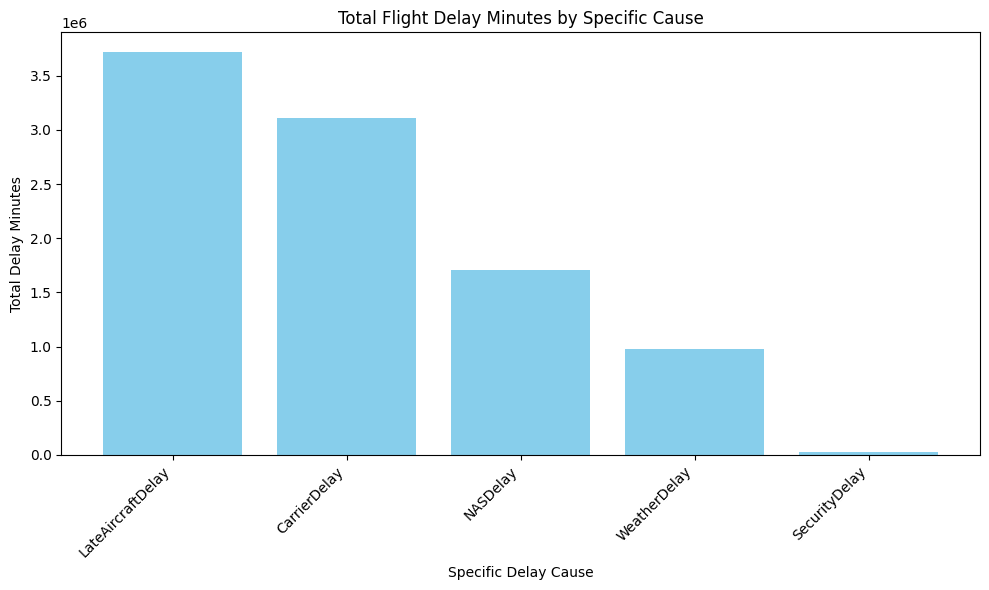


--- Analysis 2: Average arrival delay by Reporting Airline ---
Average arrival delay by Reporting Airline:
+-----------------+--------------------------+---------------+
|Reporting_Airline|AverageArrivalDelayMinutes|NumberOfFlights|
+-----------------+--------------------------+---------------+
|               AA|        26.171269361052932|          77346|
|               F9|        23.788441477154183|          14379|
|               OO|        23.171771042348716|          56814|
|               B6|         23.13115423901941|          19580|
|               OH|         22.81828633668159|          16526|
|               G4|        21.916472778036297|           8596|
|               9E|        20.742693848691964|          16972|
|               MQ|        19.236530120481927|          20750|
|               NK|         17.90120009796718|          20415|
|               UA|        17.316948432588564|          58855|
+-----------------+--------------------------+---------------+
only showi

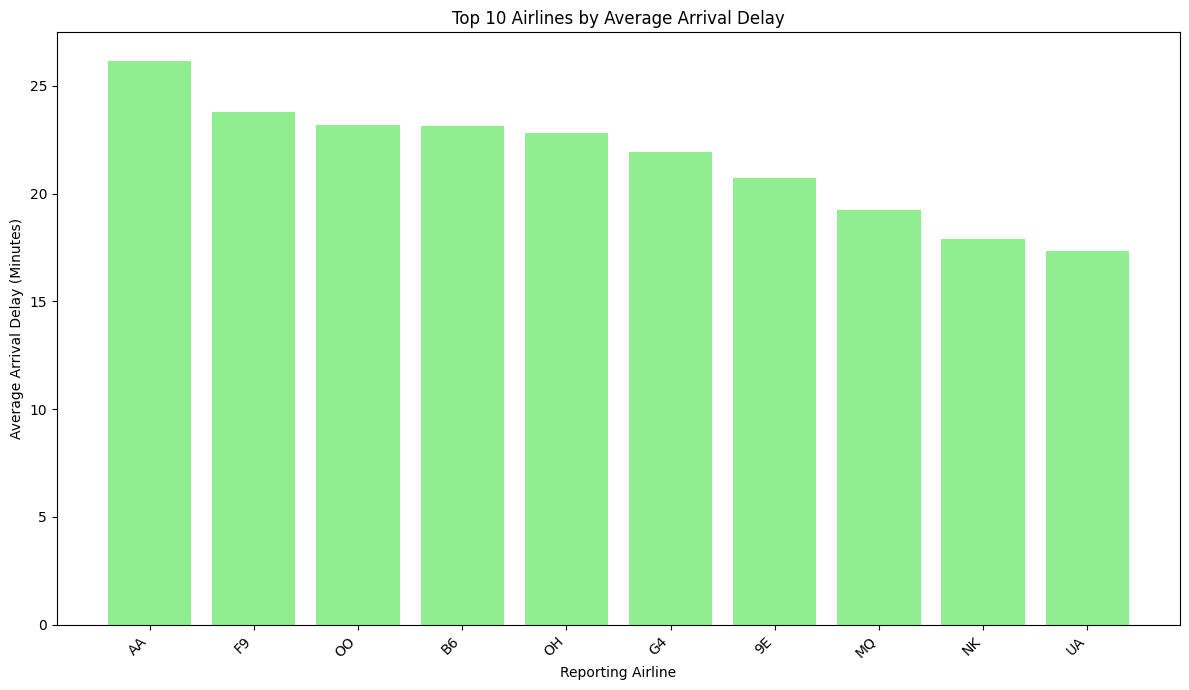


--- Analysis 3: Average arrival delay by Origin Airport ---
Average arrival delay by Origin Airport:
+------+--------------------------+---------------+
|Origin|AverageArrivalDelayMinutes|NumberOfFlights|
+------+--------------------------+---------------+
|   CKB|                      86.2|             15|
|   ELM|         80.38157894736842|             76|
|   STC|         69.11111111111111|             18|
|   SMX|         67.33333333333333|              9|
|   PSM|         59.47826086956522|             23|
|   IMT|        57.967213114754095|             61|
|   SWF|        55.766666666666666|             30|
|   CIU|        55.442622950819676|             61|
|   AVP|                   49.3125|            128|
|   RDM|         47.20204081632653|            490|
+------+--------------------------+---------------+
only showing top 10 rows



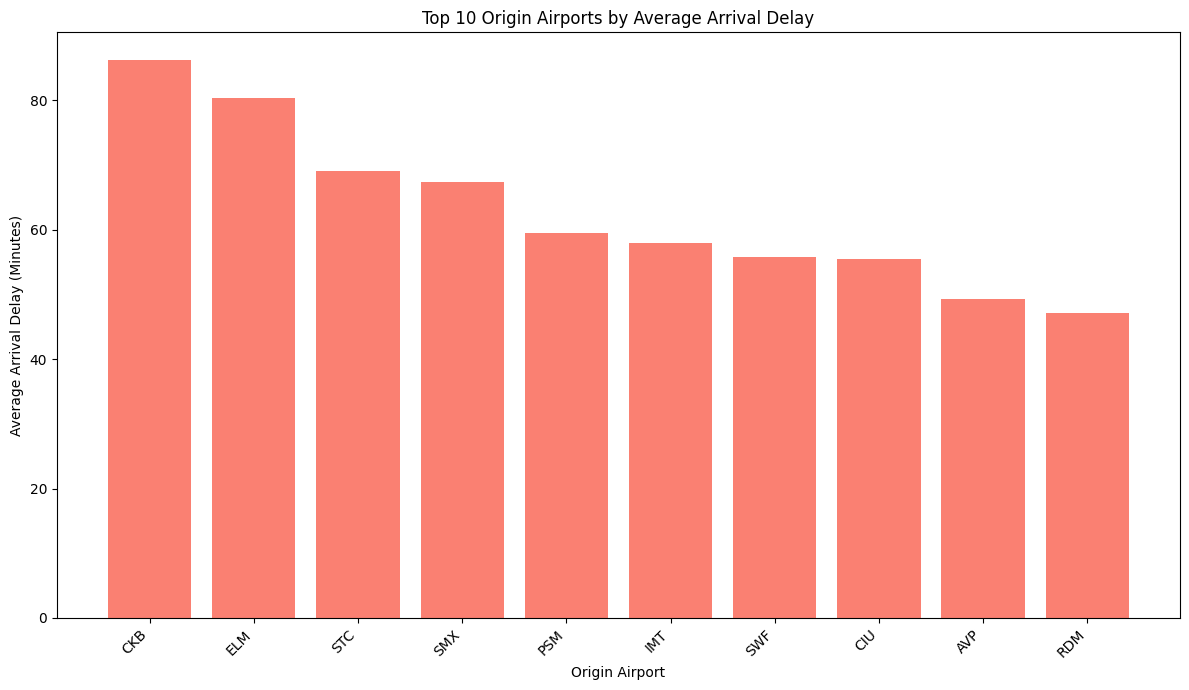


--- Analysis 4: Average arrival delay by Day of Week ---
Average arrival delay by Day of Week:
   DayOfWeek  AverageArrivalDelayMinutes  NumberOfFlights
0     Monday                   21.397792            91299
1    Tuesday                   23.893298            85106
2  Wednesday                   13.705141            85719
3   Thursday                   12.593387            73913
4     Friday                   20.361379            74105
5   Saturday                   17.854819            63514
6     Sunday                   18.362019            73615


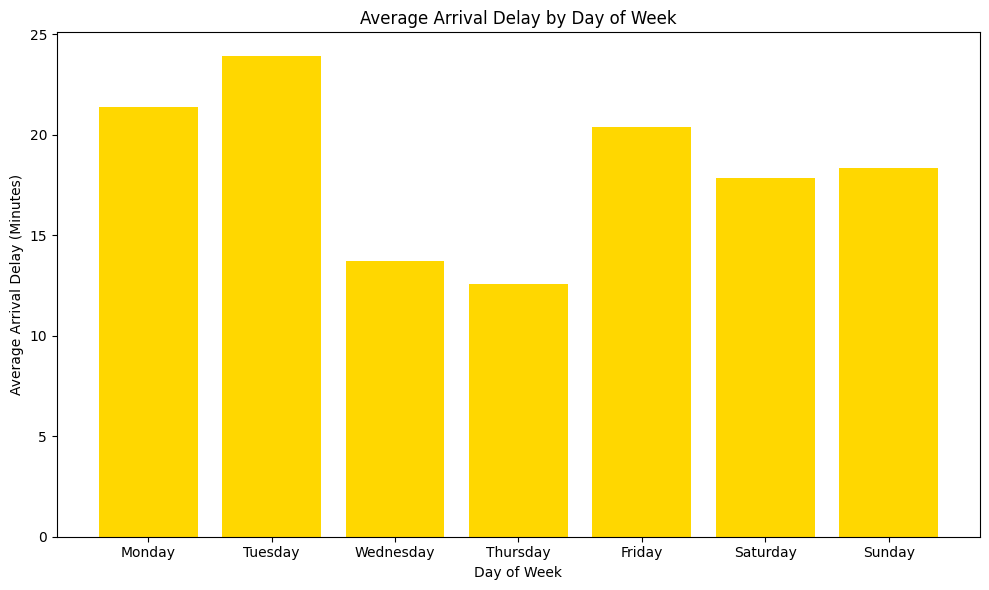


--- Analysis 5: Percentage contribution of each specific delay type ---
Percentage contribution of each specific delay type:
          DelayCause  TotalDelayMinutes  Percentage
4  LateAircraftDelay          3715582.0   38.952855
0       CarrierDelay          3111412.0   32.618950
2           NASDelay          1709694.0   17.923831
1       WeatherDelay           979360.0   10.267266
3      SecurityDelay            22616.0    0.237098


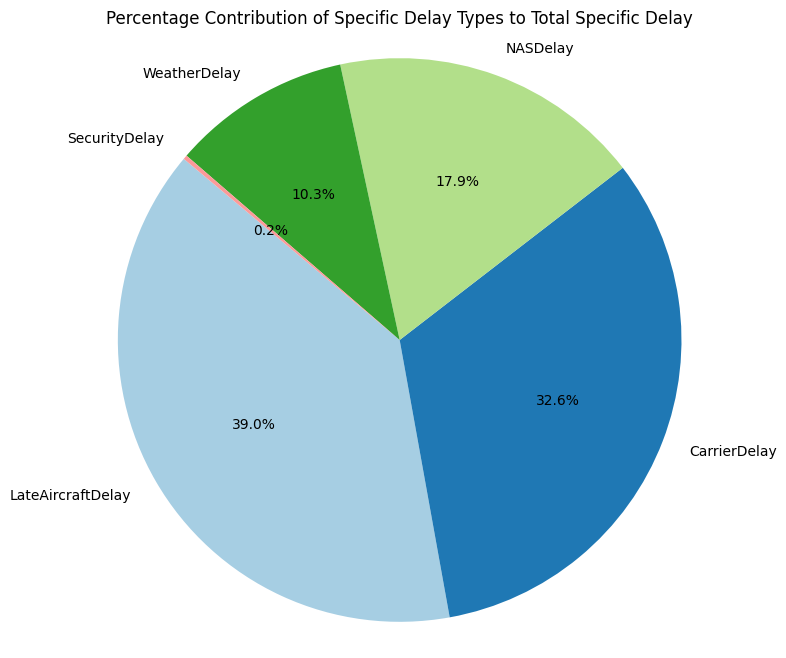


--- Analysis 6: Average arrival delay by Arrival Time Block ---
Average arrival delay by Arrival Time Block:
+----------+--------------------------+---------------+
|ArrTimeBlk|AverageArrivalDelayMinutes|NumberOfFlights|
+----------+--------------------------+---------------+
| 0001-0559|         21.20387997461699|          11031|
| 0600-0659|         16.94051139328579|           5749|
| 0700-0759|         14.49051597051597|          20350|
| 0800-0859|         13.36983180834504|          26339|
| 0900-0959|         14.13657712970069|          32575|
| 1000-1059|        13.968716780561882|          32925|
| 1100-1159|         15.47668346590564|          32938|
| 1200-1259|        15.405383525602105|          34587|
| 1300-1359|         16.60729904527256|          32470|
| 1400-1459|         17.36763691957193|          33359|
| 1500-1559|        18.572666958753207|          31954|
| 1600-1659|        19.146483526036686|          34509|
| 1700-1759|        21.170711753476958|          3

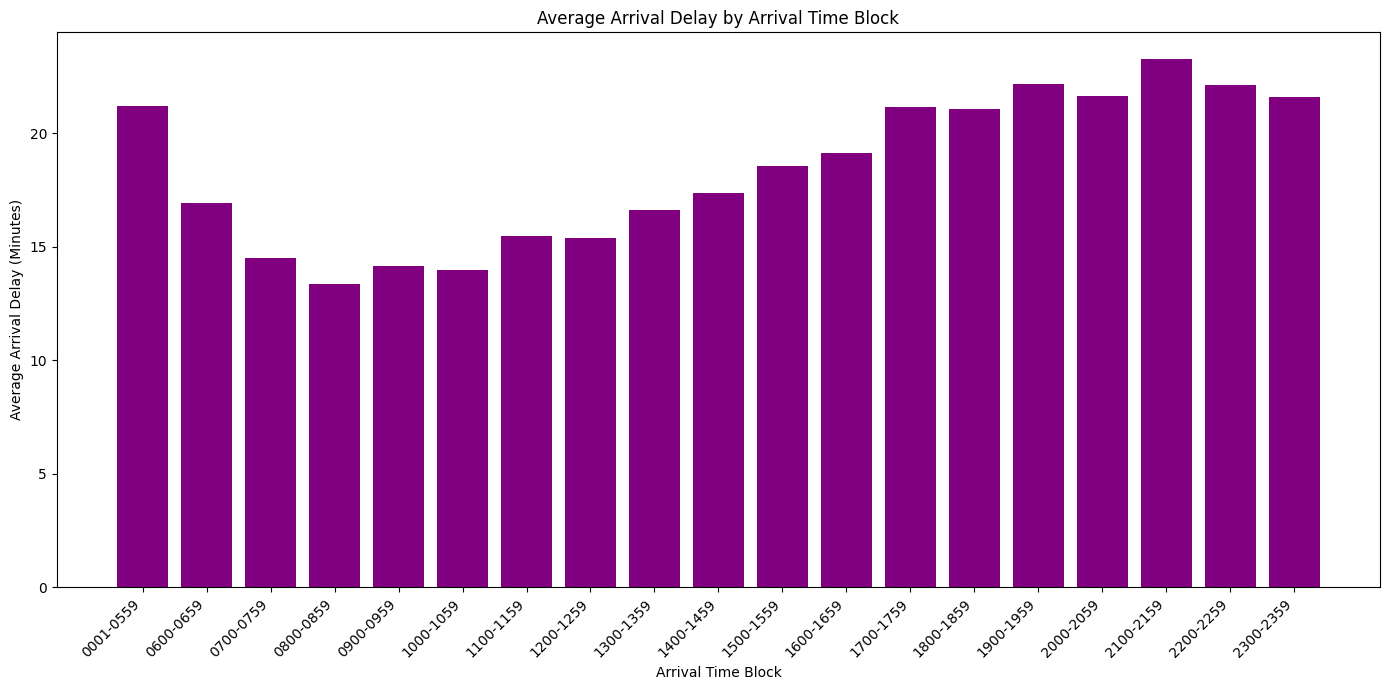


--- Analysis 7: Average arrival delay by Destination Airport ---
Average arrival delay by Destination Airport:
+----+--------------------------+---------------+
|Dest|AverageArrivalDelayMinutes|NumberOfFlights|
+----+--------------------------+---------------+
| CKB|         84.46666666666667|             15|
| ELM|         68.53947368421052|             76|
| JLN|        57.666666666666664|             51|
| JST|         49.75806451612903|             62|
| MBS|        49.579268292682926|            164|
| IMT|        49.557377049180324|             61|
| LAN|         47.29126213592233|            103|
| GUC|                      46.5|            100|
| CSG|        44.573170731707314|             82|
| DHN|         44.12903225806452|             62|
+----+--------------------------+---------------+
only showing top 10 rows



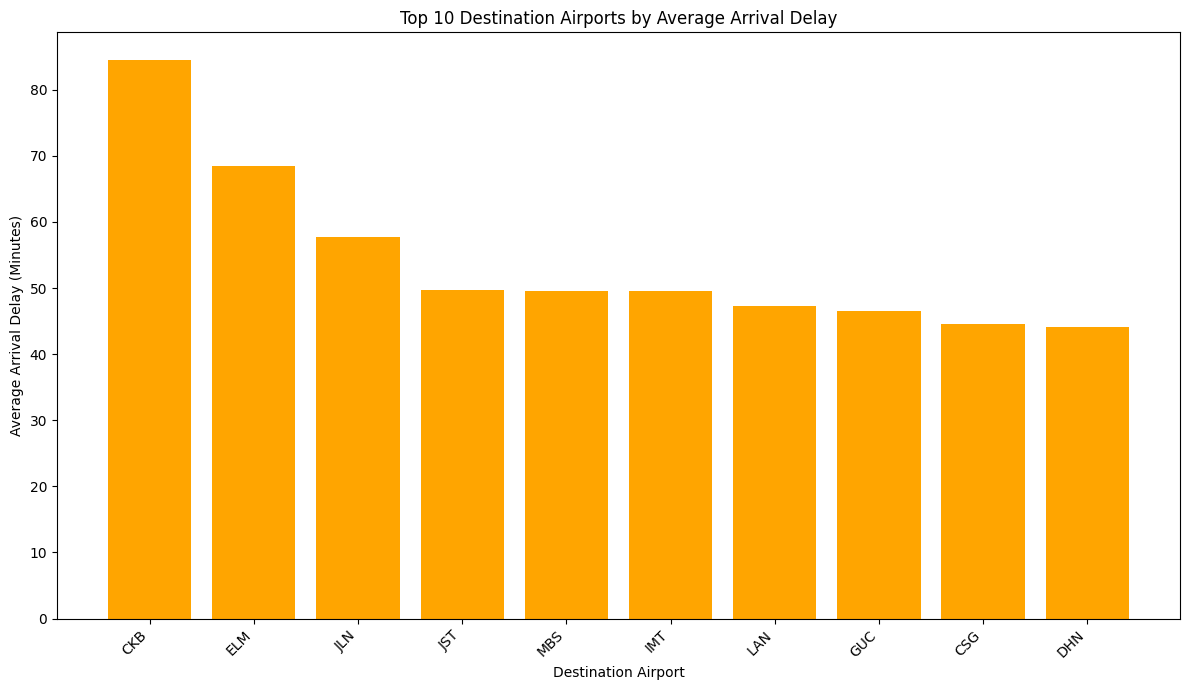


--- Analysis 8: Total Cancelled Flights by Reporting Airline ---
Total Cancelled Flights by Reporting Airline:
+-----------------+---------------------+
|Reporting_Airline|TotalCancelledFlights|
+-----------------+---------------------+
|               UA|                 4714|
|               WN|                 3566|
|               AS|                 3119|
|               OO|                 2384|
|               AA|                 1248|
|               YX|                 1061|
|               OH|                  944|
|               MQ|                  932|
|               9E|                  706|
|               DL|                  478|
+-----------------+---------------------+
only showing top 10 rows



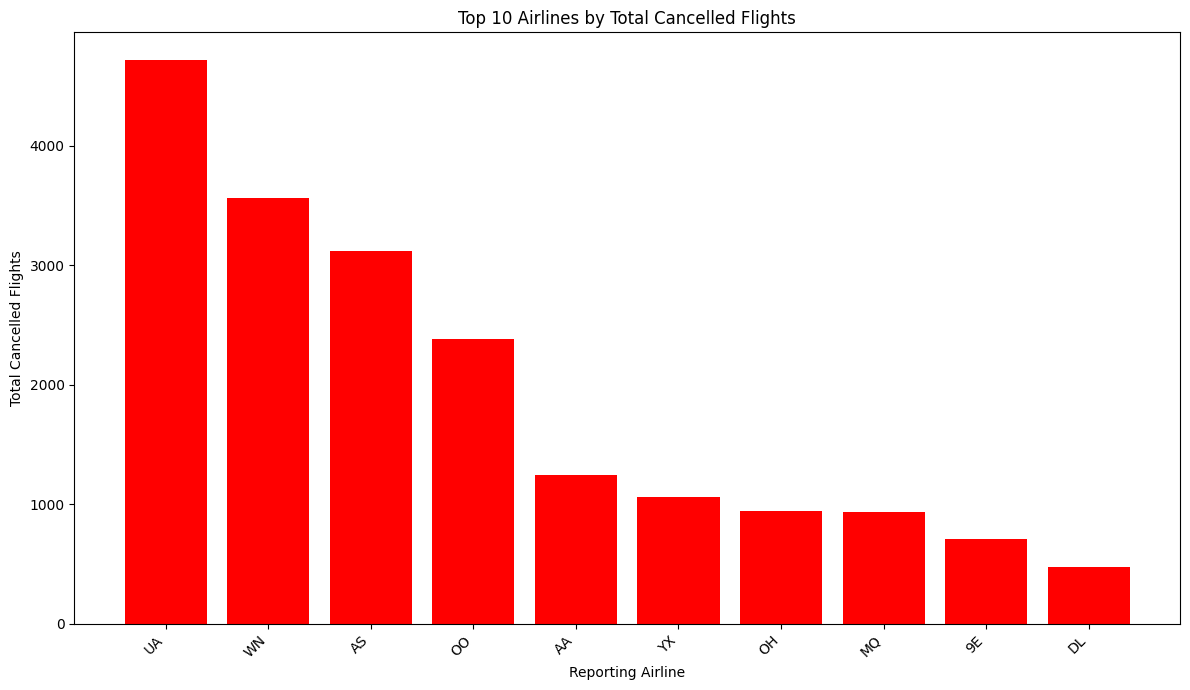


--- Analysis 9: Average Departure Delay by Origin Airport ---
Average departure delay by Origin Airport:
+------+----------------------------+---------------+
|Origin|AverageDepartureDelayMinutes|NumberOfFlights|
+------+----------------------------+---------------+
|   CKB|                        86.0|             15|
|   ELM|            82.8157894736842|             76|
|   STC|           71.61111111111111|             18|
|   SMX|           69.66666666666667|              9|
|   PSM|           57.47826086956522|             23|
|   IMT|          56.622950819672134|             61|
|   CIU|           55.49180327868852|             61|
|   SWF|           51.53333333333333|             30|
|   AVP|                  49.8984375|            128|
|   DEC|           46.74698795180723|             83|
+------+----------------------------+---------------+
only showing top 10 rows



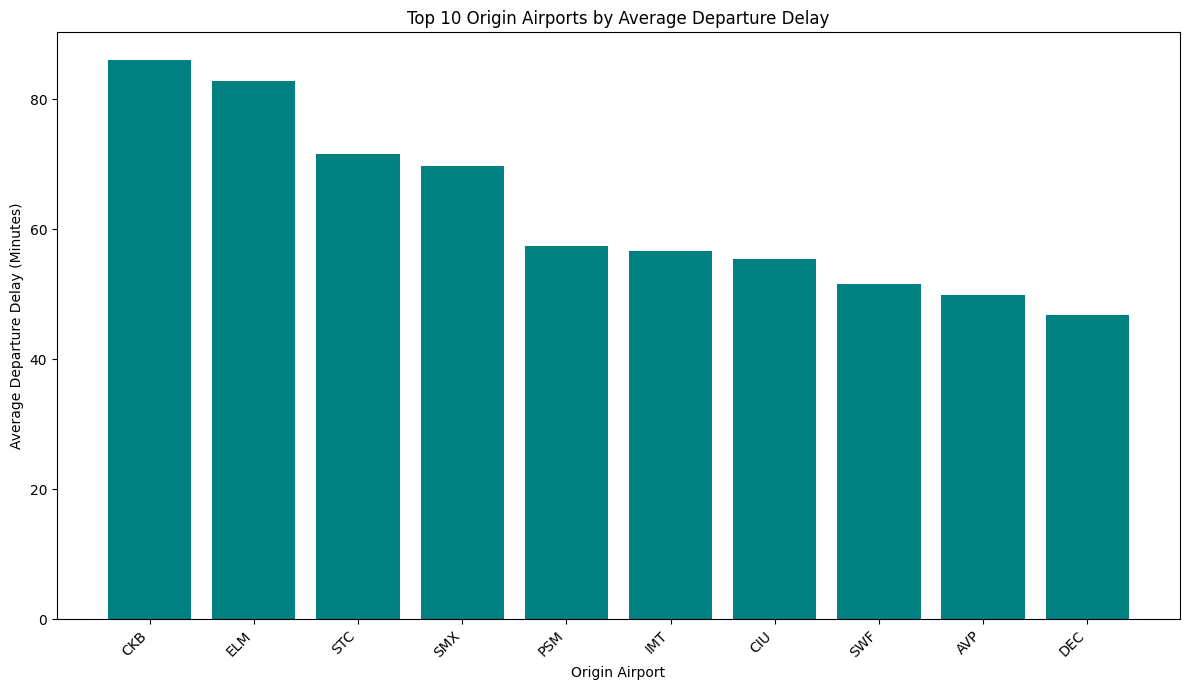


--- Analysis 10: Average Departure Delay by Departure Time Block ---
Average departure delay by Departure Time Block:
+----------+----------------------------+---------------+
|DepTimeBlk|AverageDepartureDelayMinutes|NumberOfFlights|
+----------+----------------------------+---------------+
| 0001-0559|          14.807769549391239|          15934|
| 0600-0659|           11.26906572310472|          39849|
| 0700-0759|          11.546916604537225|          37556|
| 0800-0859|          11.984383502013277|          36756|
| 0900-0959|          13.570017838939858|          31392|
| 1000-1059|          15.904470735453046|          35162|
| 1100-1159|          16.945859404835346|          34041|
| 1200-1259|          18.760561264347096|          33282|
| 1300-1359|          19.825340959084908|          34095|
| 1400-1459|          20.168076532652496|          32509|
| 1500-1559|           21.19881490721971|          32065|
| 1600-1659|           21.17842645099315|          32271|
| 1700-1759

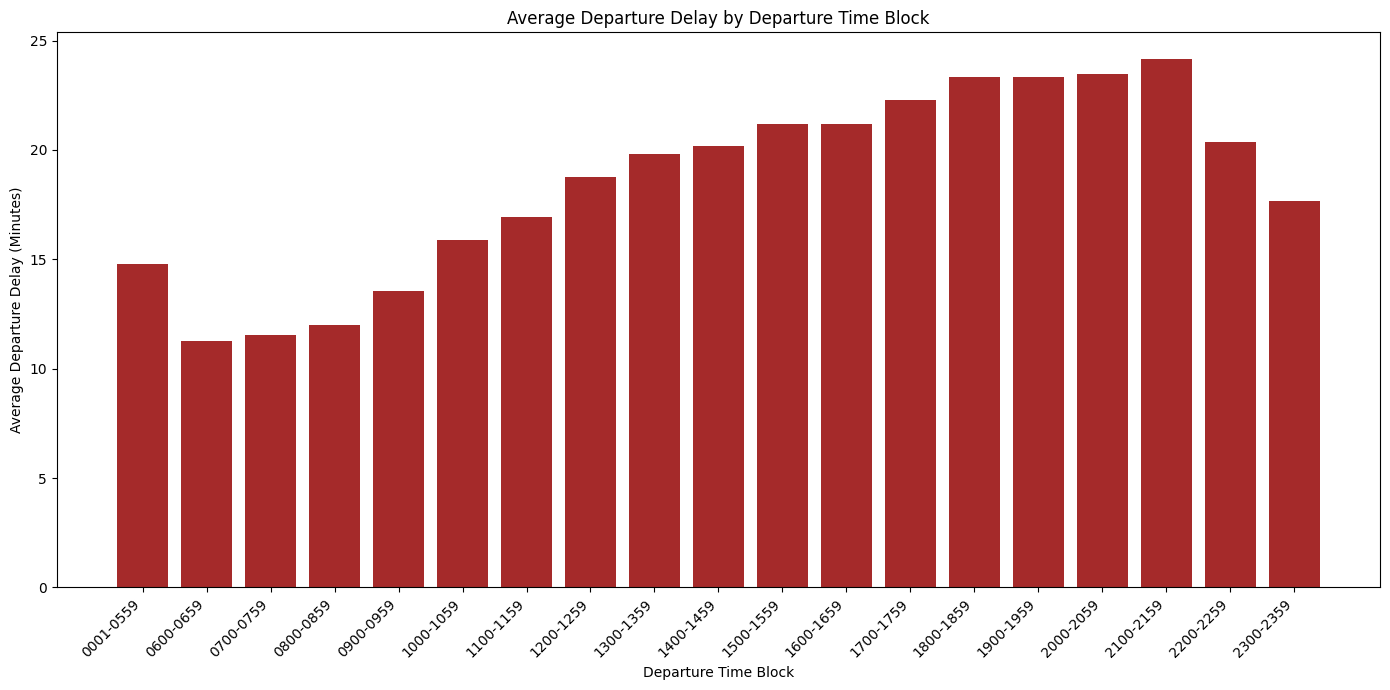


--- Analysis 11: Average Delay by Month ---
Average delay by Month:
  Month  AverageArrivalDelayMinutes  NumberOfFlights
0   Jan                   18.431996           547271


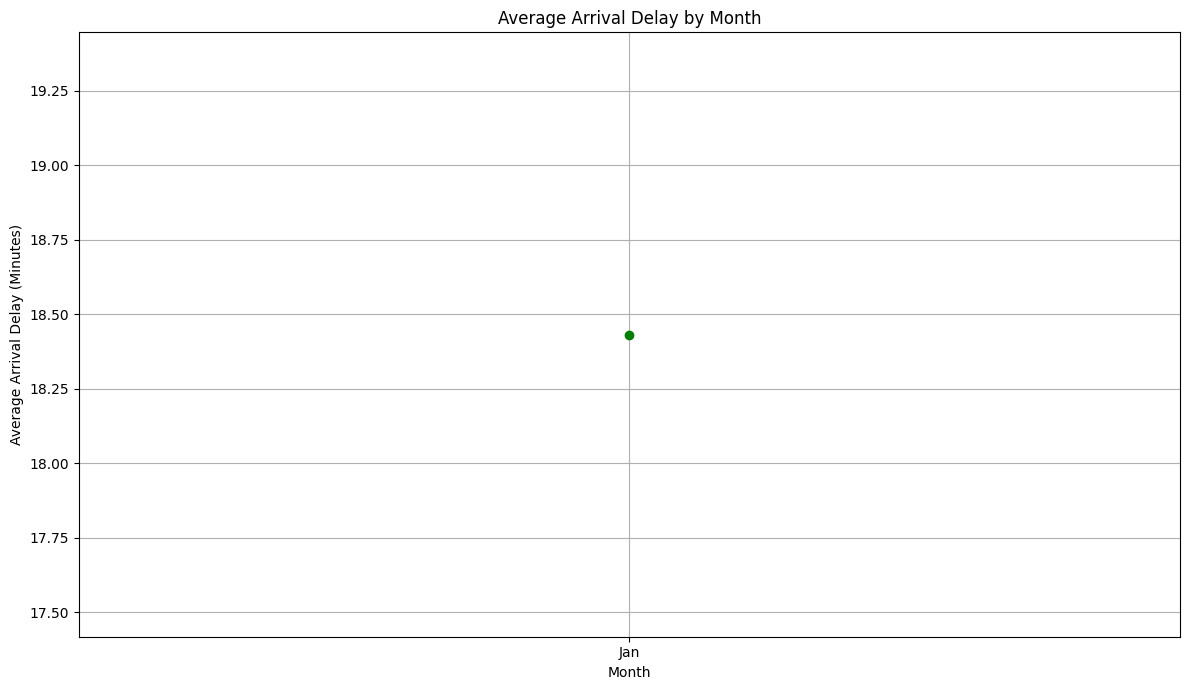


--- Analysis 12: Relationship between Distance and Average Delay ---
Average delay by Distance Group:
+-------------+--------------------------+---------------+
|DistanceGroup|AverageArrivalDelayMinutes|NumberOfFlights|
+-------------+--------------------------+---------------+
|            1|         19.35524555704185|          62796|
|            2|        17.415725793139877|         121164|
|            3|        18.657195667923688|         107662|
|            4|        18.901621398998547|          92266|
|            5|        20.479975140557023|          69189|
|            6|         18.15220372184133|          25525|
|            7|        17.830143149284254|          24450|
|            8|        15.526363145582149|          11114|
|            9|         15.74699614599864|           8822|
|           10|        14.618581907090464|          13088|
|           11|         16.96998660116123|          11195|
+-------------+--------------------------+---------------+



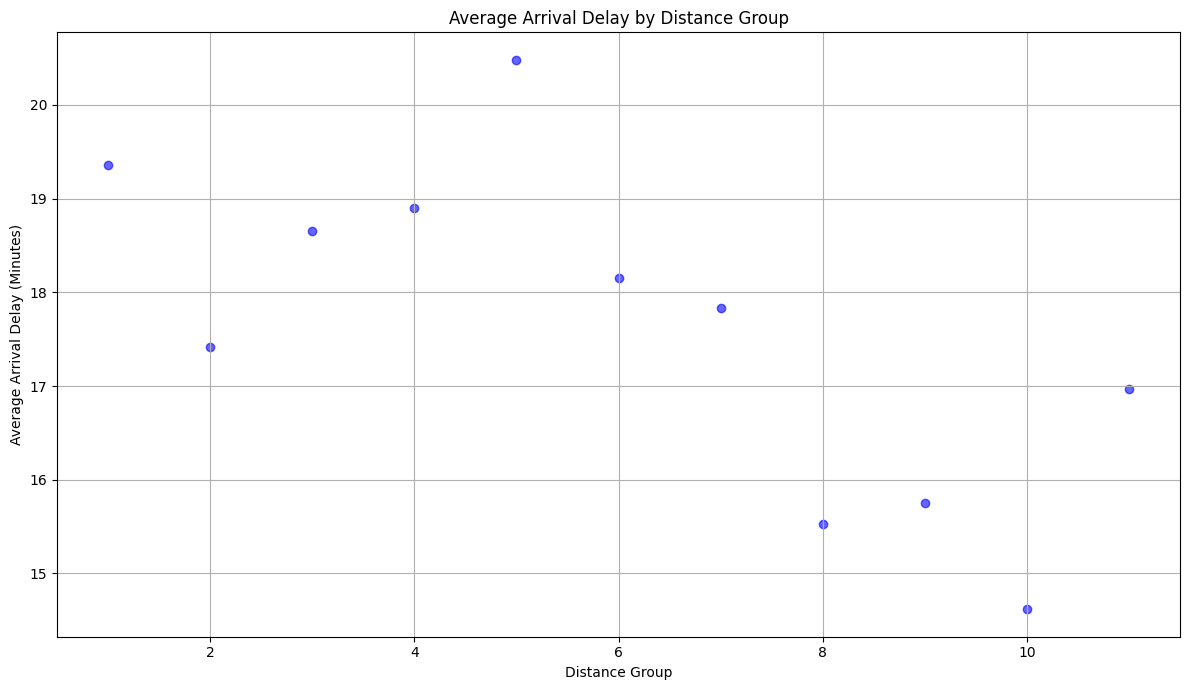


--- Analysis 13: Average Departure Delay by Hour of Day ---
Average departure delay by Hour of Day:
+-------------+----------------------------+---------------+
|DepartureHour|AverageDepartureDelayMinutes|NumberOfFlights|
+-------------+----------------------------+---------------+
|            0|           8.404887442116364|          21811|
|            1|          102.72506738544475|            742|
|            2|          136.01384083044982|            289|
|            3|           78.67647058823529|            136|
|            4|           6.054849884526559|           1732|
|            5|          2.3677980604677695|          21036|
|            6|          4.5929910398490925|          33928|
|            7|            9.25608194622279|          32021|
|            8|          11.722171671216257|          32970|
|            9|          14.775295663600525|          29679|
|           10|          15.405631026091243|          32463|
|           11|          17.140559352856336| 

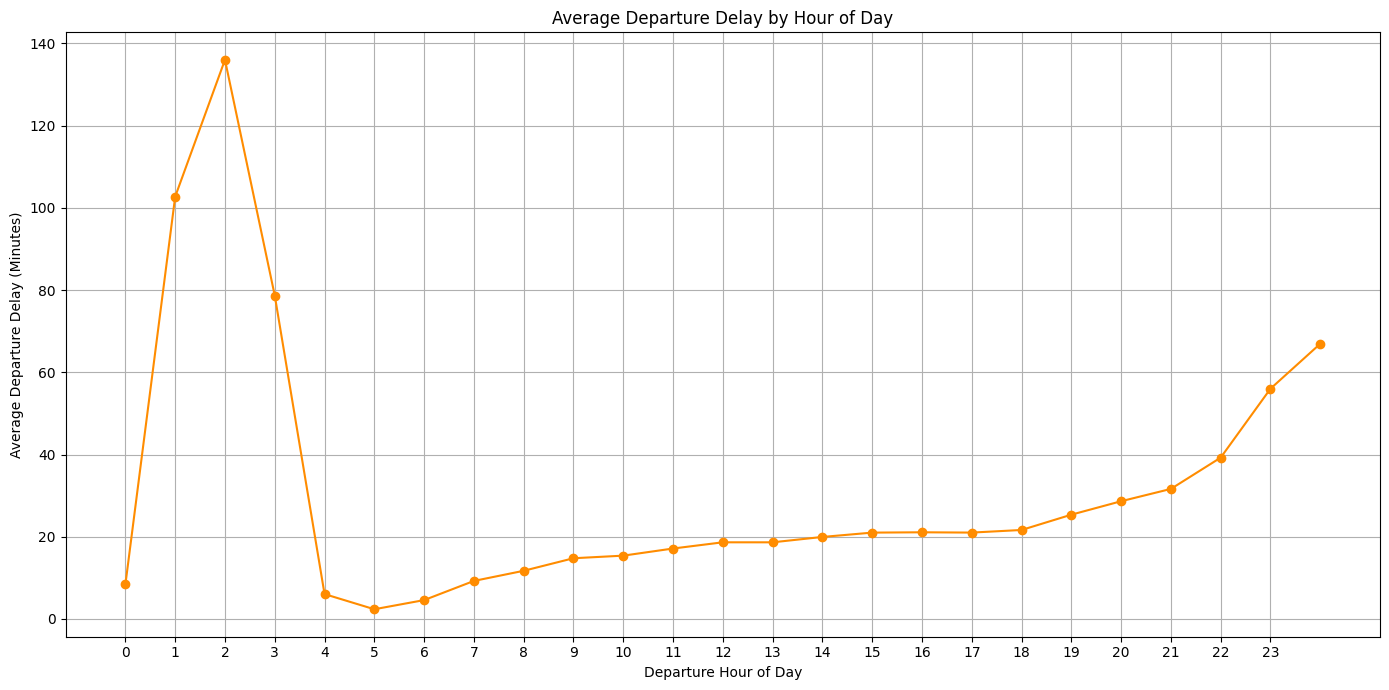


--- Analysis 14: Average Arrival Delay by Hour of Day ---
Average arrival delay by Hour of Day:
+-----------+--------------------------+---------------+
|ArrivalHour|AverageArrivalDelayMinutes|NumberOfFlights|
+-----------+--------------------------+---------------+
|          0|         16.58242666754853|          30239|
|          1|        108.68436200831468|           3127|
|          2|        160.78092783505156|           1164|
|          3|         179.2046332046332|            518|
|          4|         36.37251356238698|           1106|
|          5|         9.209347614410905|           3081|
|          6|         6.661800486618005|           6576|
|          7|         4.735324838103196|          19148|
|          8|         7.209190080050227|          25484|
|          9|          9.60818119243502|          30509|
|         10|        13.654240106418357|          30070|
|         11|        13.950804524454357|          31385|
|         12|        15.734631051960571|        

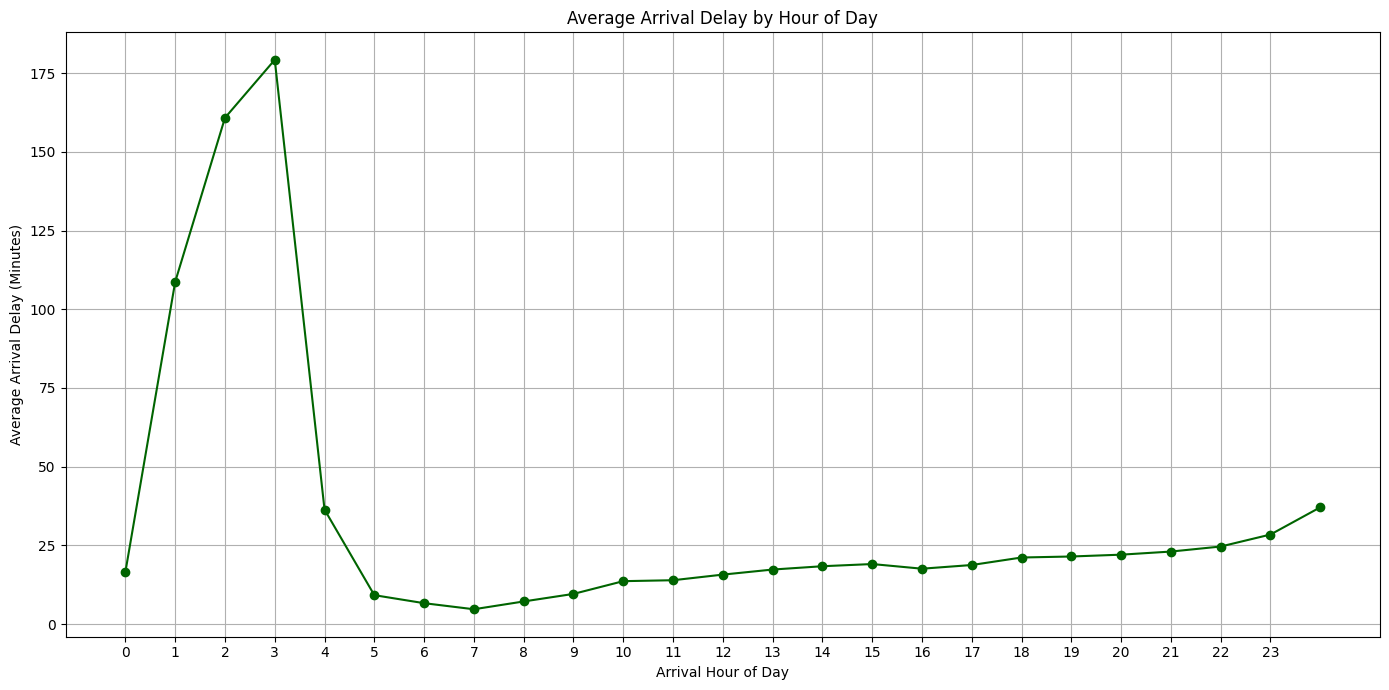


--- Analysis 15: Average Arrival Delay by Airline and Origin Airport Combination ---
Average arrival delay by Airline and Origin Airport Combination (Top 10):
+-----------------+------+--------------------------+---------------+
|Reporting_Airline|Origin|AverageArrivalDelayMinutes|NumberOfFlights|
+-----------------+------+--------------------------+---------------+
|               OH|   SYR|                     186.5|              8|
|               G4|   MSY|                   138.625|              8|
|               OO|   PHL|        124.58333333333333|             12|
|               OO|   RIC|                     123.0|             20|
|               B6|   MSP|        122.06451612903226|             31|
|               AA|   PWM|        117.50847457627118|             59|
|               HA|   BOS|        114.66666666666667|             18|
|               MQ|   ACT|        109.93333333333334|             15|
|               DL|   CID|        109.74193548387096|             31|


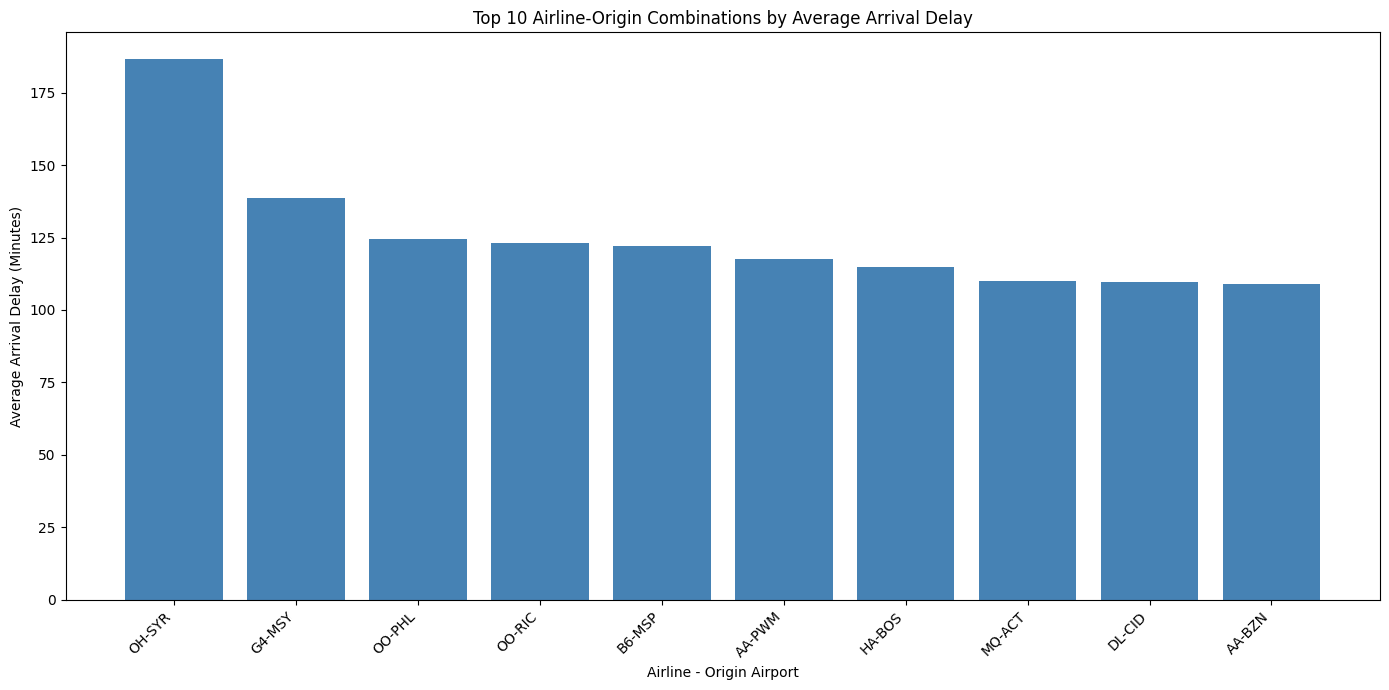


--- Analysis 16: Average Arrival Delay by Airline and Destination Airport Combination ---
Average arrival delay by Airline and Destination Airport Combination (Top 10):
+-----------------+----+--------------------------+---------------+
|Reporting_Airline|Dest|AverageArrivalDelayMinutes|NumberOfFlights|
+-----------------+----+--------------------------+---------------+
|               G4| MSY|                     141.5|              8|
|               MQ| RST|        117.83333333333333|              6|
|               OO| BDL|                      93.0|              1|
|               G4| GTF|         91.11764705882354|             17|
|               OO| ELM|         89.87272727272727|             55|
|               G4| CKB|         84.46666666666667|             15|
|               OO| AVP|         77.47826086956522|             23|
|               9E| EYW|         73.67647058823529|             34|
|               G4| RNO|                      72.0|              3|
|             

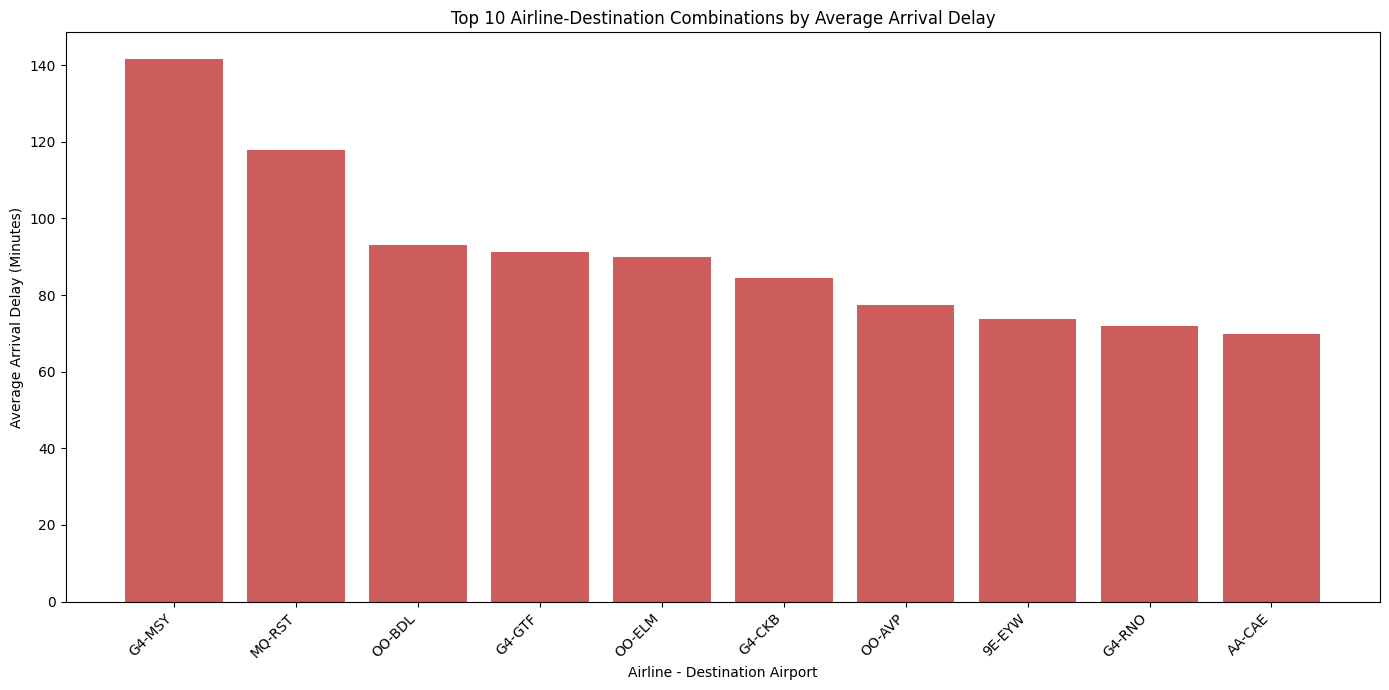


--- Overall Interpretation ---
Analysis of the flight delay dataset reveals several key patterns:

Specific Delay Causes:
The most significant specific causes of delay by total accumulated minutes are:
- LateAircraftDelay: 3715582.00 minutes
- CarrierDelay: 3111412.00 minutes
- NASDelay: 1709694.00 minutes
- WeatherDelay: 979360.00 minutes
- SecurityDelay: 22616.00 minutes

Airline Performance:
Airlines with the highest average arrival delays include:
- AA: 26.17 minutes (based on 77346 flights)
- F9: 23.79 minutes (based on 14379 flights)
- OO: 23.17 minutes (based on 56814 flights)
- B6: 23.13 minutes (based on 19580 flights)
- OH: 22.82 minutes (based on 16526 flights)
- G4: 21.92 minutes (based on 8596 flights)
- 9E: 20.74 minutes (based on 16972 flights)
- MQ: 19.24 minutes (based on 20750 flights)
- NK: 17.90 minutes (based on 20415 flights)
- UA: 17.32 minutes (based on 58855 flights)

Airport Hotspots (Origin - Arrival Delay):
Origin airports experiencing the highest average a

In [6]:
# Check if the Spark session is active before attempting to load data
# This approach checks the underlying Java SparkContext status
# If you see an error here, please restart the Colab runtime (Runtime -> Restart runtime)
if spark.sparkContext._jsc is None or spark.sparkContext._jsc.sc().isStopped():
    print("Error: SparkContext is stopped. Cannot load data. Please restart the Colab runtime.")
    data_loaded = False
else:
    # Check if the path(s) exist and load data
    data_loaded = False
    if isinstance(file_paths, str):
        # If file_paths is a string, check if the directory exists
        if not os.path.exists(file_paths):
            print(f"Error: The specified directory '{file_paths}' does not exist.")
        else:
            try:
                df = spark.read.csv(file_paths, header=True, inferSchema=True)
                print(f"Dataset(s) loaded from directory: {file_paths}")
                data_loaded = True
            except Exception as e:
                print(f"An error occurred while reading data from directory {file_paths}: {e}")
    elif isinstance(file_paths, list):
        # If file_paths is a list, Spark can handle reading multiple files directly
        # We can optionally check if each file exists, but Spark will error if not found during read
        all_files_exist = True
        for f_path in file_paths:
            if not os.path.exists(f_path):
                print(f"Warning: File '{f_path}' does not exist.")
                all_files_exist = False # Or you might choose to break and not attempt reading

        if all_files_exist and file_paths: # Ensure the list is not empty
            try:
                df = spark.read.csv(file_paths, header=True, inferSchema=True)
                print(f"Dataset(s) loaded from list of files: {file_paths}")
                data_loaded = True
            except Exception as e:
                print(f"An error occurred while reading data from list of files {file_paths}: {e}")
        elif not file_paths:
            print("Error: The list of file paths is empty.")
    else:
        print(f"Error: Invalid type for file_paths. Expected string or list, but got {type(file_paths)}")


# Proceed with analysis only if data was loaded successfully
if data_loaded:
    # 3. Data Exploration and Preprocessing:
    # Display the schema and a few rows of the DataFrame.
    print("Dataset Schema:")
    df.printSchema()

    print("\nFirst 5 rows of the dataset:")
    df.show(5)

    # Handle missing values or incorrect data types in relevant columns.
    # The delay columns are CarrierDelay, WeatherDelay, NASDelay, SecurityDelay, LateAircraftDelay.
    # Coalesce null values in delay columns to 0, as null likely means no delay of that type.
    delay_columns = ['CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay', 'ArrDelayMinutes', 'DepDelayMinutes']
    for delay_col in delay_columns:
        df = df.withColumn(delay_col, coalesce(col(delay_col), lit(0.0)))

    # Ensure delay columns are numeric (inferSchema should handle this, but good practice to be aware)
    # If schema inference fails, you might need to cast columns:
    # from pyspark.sql.types import DoubleType
    # for delay_col in delay_columns:
    #     df = df.withColumn(delay_col, col(delay_col).cast(DoubleType()))

    print("\nSchema after handling potential nulls in delay columns:")
    df.printSchema()

    # Add a total delay column for easier analysis (sum of specific delay types)
    specific_delay_cols = ['CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay']
    delay_cols_to_sum = [col(c) for c in specific_delay_cols]
    if delay_cols_to_sum: # Ensure the list is not empty
        total_specific_delay_expression = reduce(lambda x, y: x + y, delay_cols_to_sum)
        df = df.withColumn("TotalSpecificDelayMinutes", total_specific_delay_expression)
    else:
        # Handle case where there are no specific delay columns to sum
        df = df.withColumn("TotalSpecificDelayMinutes", lit(0.0)) # Or handle as appropriate


    # 4. Delay Analysis:

    # Analysis 1: Total delay minutes by specific cause
    print("\n--- Analysis 1: Total delay minutes by specific cause ---")
    delay_cause_totals = df.agg(
        sum("CarrierDelay").alias("CarrierDelay_Total"),
        sum("WeatherDelay").alias("WeatherDelay_Total"),
        sum("NASDelay").alias("NASDelay_Total"),
        sum("SecurityDelay").alias("SecurityDelay_Total"),
        sum("LateAircraftDelay").alias("LateAircraftDelay_Total")
    )

    print("Total delay minutes by cause:")
    delay_cause_totals.show()

    # Convert to Pandas for visualization and finding top causes
    delay_totals_pd = delay_cause_totals.toPandas()
    delay_totals_unpivoted = delay_totals_pd.melt(var_name='DelayCause', value_name='TotalDelayMinutes')
    delay_totals_unpivoted['DelayCause'] = delay_totals_unpivoted['DelayCause'].str.replace('_Total', '')
    top_causes_total = delay_totals_unpivoted.sort_values(by='TotalDelayMinutes', ascending=False)

    N_causes = 5 # Number of top causes to display
    print(f"\nTop {N_causes} Specific Delay Causes (by total minutes):")
    print(top_causes_total.head(min(N_causes, len(top_causes_total))))

    # Visualization 1: Bar chart of total delay minutes by specific cause
    plt.figure(figsize=(10, 6))
    plt.bar(top_causes_total['DelayCause'], top_causes_total['TotalDelayMinutes'], color='skyblue')
    plt.xlabel('Specific Delay Cause')
    plt.ylabel('Total Delay Minutes')
    plt.title('Total Flight Delay Minutes by Specific Cause')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


    # Analysis 2: Average arrival delay by Reporting Airline
    print("\n--- Analysis 2: Average arrival delay by Reporting Airline ---")
    avg_delay_by_airline = df.groupBy("Reporting_Airline").agg(
        avg("ArrDelayMinutes").alias("AverageArrivalDelayMinutes"),
        count("*").alias("NumberOfFlights")
    ).orderBy(desc("AverageArrivalDelayMinutes"))

    print("Average arrival delay by Reporting Airline:")
    avg_delay_by_airline.show(10) # Show top 10 airlines by average delay

    # Visualization 2: Bar chart of average arrival delay by Reporting Airline (Top 10)
    # Apply limit to Spark DataFrame before converting to Pandas
    avg_delay_airline_pd = avg_delay_by_airline.limit(10).toPandas()
    plt.figure(figsize=(12, 7))
    plt.bar(avg_delay_airline_pd['Reporting_Airline'], avg_delay_airline_pd['AverageArrivalDelayMinutes'], color='lightgreen')
    plt.xlabel('Reporting Airline')
    plt.ylabel('Average Arrival Delay (Minutes)')
    plt.title('Top 10 Airlines by Average Arrival Delay')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    # Analysis 3: Average arrival delay by Origin Airport
    print("\n--- Analysis 3: Average arrival delay by Origin Airport ---")
    avg_delay_by_origin = df.groupBy("Origin").agg(
        avg("ArrDelayMinutes").alias("AverageArrivalDelayMinutes"),
        count("*").alias("NumberOfFlights")
    ).orderBy(desc("AverageArrivalDelayMinutes"))

    print("Average arrival delay by Origin Airport:")
    avg_delay_by_origin.show(10) # Show top 10 origin airports by average delay

    # Visualization 3: Bar chart of average arrival delay by Origin Airport (Top 10)
    # Apply limit to Spark DataFrame before converting to Pandas
    avg_delay_origin_pd = avg_delay_by_origin.limit(10).toPandas()
    plt.figure(figsize=(12, 7))
    plt.bar(avg_delay_origin_pd['Origin'], avg_delay_origin_pd['AverageArrivalDelayMinutes'], color='salmon')
    plt.xlabel('Origin Airport')
    plt.ylabel('Average Arrival Delay (Minutes)')
    plt.title('Top 10 Origin Airports by Average Arrival Delay')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


    # Analysis 4: Average arrival delay by Day of Week
    print("\n--- Analysis 4: Average arrival delay by Day of Week ---")
    # Map day of week number to name for better readability
    avg_delay_by_dayofweek = df.groupBy("DayOfWeek").agg(
        avg("ArrDelayMinutes").alias("AverageArrivalDelayMinutes"),
        count("*").alias("NumberOfFlights")
    ).orderBy("DayOfWeek") # Order by day number (1=Monday, 7=Sunday)

    # Convert to Pandas to map day number to name and plot
    avg_delay_dayofweek_pd = avg_delay_by_dayofweek.toPandas()
    day_names = {1: 'Monday', 2: 'Tuesday', 3: 'Wednesday', 4: 'Thursday', 5: 'Friday', 6: 'Saturday', 7: 'Sunday'}
    avg_delay_dayofweek_pd['DayOfWeek'] = avg_delay_dayofweek_pd['DayOfWeek'].map(day_names)

    print("Average arrival delay by Day of Week:")
    print(avg_delay_dayofweek_pd)

    # Visualization 4: Bar chart of average arrival delay by Day of Week
    plt.figure(figsize=(10, 6))
    plt.bar(avg_delay_dayofweek_pd['DayOfWeek'], avg_delay_dayofweek_pd['AverageArrivalDelayMinutes'], color='gold')
    plt.xlabel('Day of Week')
    plt.ylabel('Average Arrival Delay (Minutes)')
    plt.title('Average Arrival Delay by Day of Week')
    plt.tight_layout()
    plt.show()

    # Analysis 5: Percentage contribution of each specific delay type to total specific delay
    print("\n--- Analysis 5: Percentage contribution of each specific delay type ---")

    total_sum_of_specific_delays = delay_cause_totals.agg(sum(col("CarrierDelay_Total") + col("WeatherDelay_Total") + col("NASDelay_Total") + col("SecurityDelay_Total") + col("LateAircraftDelay_Total"))).collect()[0][0]

    if total_sum_of_specific_delays is not None and total_sum_of_specific_delays > 0:
        delay_cause_percentages = delay_totals_unpivoted.copy()
        delay_cause_percentages['Percentage'] = (delay_cause_percentages['TotalDelayMinutes'] / total_sum_of_specific_delays) * 100
        delay_cause_percentages_sorted = delay_cause_percentages.sort_values(by='Percentage', ascending=False)

        print("Percentage contribution of each specific delay type:")
        print(delay_cause_percentages_sorted)

        # Visualization 5: Pie chart of percentage contribution of specific delay types
        plt.figure(figsize=(8, 8))
        plt.pie(delay_cause_percentages_sorted['Percentage'], labels=delay_cause_percentages_sorted['DelayCause'], autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)
        plt.title('Percentage Contribution of Specific Delay Types to Total Specific Delay')
        plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
        plt.show()
    else:
        print("Total specific delay minutes is zero or None, cannot calculate percentages.")


    # --- Additional Analyses and Visualizations ---

    # Analysis 6: Average arrival delay by Time Block (ArrTimeBlk)
    print("\n--- Analysis 6: Average arrival delay by Arrival Time Block ---")
    avg_delay_by_time_blk = df.groupBy("ArrTimeBlk").agg(
        avg("ArrDelayMinutes").alias("AverageArrivalDelayMinutes"),
        count("*").alias("NumberOfFlights")
    ).orderBy("ArrTimeBlk") # Order by time block

    print("Average arrival delay by Arrival Time Block:")
    avg_delay_by_time_blk.show()

    # Visualization 6: Bar chart of average arrival delay by Time Block
    avg_delay_time_blk_pd = avg_delay_by_time_blk.toPandas()
    plt.figure(figsize=(14, 7))
    plt.bar(avg_delay_time_blk_pd['ArrTimeBlk'], avg_delay_time_blk_pd['AverageArrivalDelayMinutes'], color='purple')
    plt.xlabel('Arrival Time Block')
    plt.ylabel('Average Arrival Delay (Minutes)')
    plt.title('Average Arrival Delay by Arrival Time Block')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


    # Analysis 7: Average arrival delay by Destination Airport
    print("\n--- Analysis 7: Average arrival delay by Destination Airport ---")
    avg_delay_by_dest = df.groupBy("Dest").agg(
        avg("ArrDelayMinutes").alias("AverageArrivalDelayMinutes"),
        count("*").alias("NumberOfFlights")
    ).orderBy(desc("AverageArrivalDelayMinutes"))

    print("Average arrival delay by Destination Airport:")
    avg_delay_by_dest.show(10) # Show top 10 destination airports by average delay

    # Visualization 7: Bar chart of average arrival delay by Destination Airport (Top 10)
    # Apply limit to Spark DataFrame before converting to Pandas
    avg_delay_dest_pd = avg_delay_by_dest.limit(10).toPandas()
    plt.figure(figsize=(12, 7))
    plt.bar(avg_delay_dest_pd['Dest'], avg_delay_dest_pd['AverageArrivalDelayMinutes'], color='orange')
    plt.xlabel('Destination Airport')
    plt.ylabel('Average Arrival Delay (Minutes)')
    plt.title('Top 10 Destination Airports by Average Arrival Delay')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


    # Analysis 8: Total Cancelled Flights by Reporting Airline
    print("\n--- Analysis 8: Total Cancelled Flights by Reporting Airline ---")
    cancelled_flights_by_airline = df.filter(col("Cancelled") == 1.0).groupBy("Reporting_Airline").agg(
        count("*").alias("TotalCancelledFlights")
    ).orderBy(desc("TotalCancelledFlights"))

    print("Total Cancelled Flights by Reporting Airline:")
    cancelled_flights_by_airline.show(10) # Show top 10 airlines by cancelled flights

    # Visualization 8: Bar chart of Total Cancelled Flights by Reporting Airline (Top 10)
    # Apply limit to Spark DataFrame before converting to Pandas
    cancelled_flights_airline_pd = cancelled_flights_by_airline.limit(10).toPandas()
    plt.figure(figsize=(12, 7))
    plt.bar(cancelled_flights_airline_pd['Reporting_Airline'], cancelled_flights_airline_pd['TotalCancelledFlights'], color='red')
    plt.xlabel('Reporting Airline')
    plt.ylabel('Total Cancelled Flights')
    plt.title('Top 10 Airlines by Total Cancelled Flights')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    # Analysis 9: Average Departure Delay by Origin Airport
    print("\n--- Analysis 9: Average Departure Delay by Origin Airport ---")
    avg_dep_delay_by_origin = df.groupBy("Origin").agg(
        avg("DepDelayMinutes").alias("AverageDepartureDelayMinutes"),
        count("*").alias("NumberOfFlights")
    ).orderBy(desc("AverageDepartureDelayMinutes"))

    print("Average departure delay by Origin Airport:")
    avg_dep_delay_by_origin.show(10) # Show top 10 origin airports by average departure delay

    # Visualization 9: Bar chart of Average Departure Delay by Origin Airport (Top 10)
    # Apply limit to Spark DataFrame before converting to Pandas
    avg_dep_delay_origin_pd = avg_dep_delay_by_origin.limit(10).toPandas()
    plt.figure(figsize=(12, 7))
    plt.bar(avg_dep_delay_origin_pd['Origin'], avg_dep_delay_origin_pd['AverageDepartureDelayMinutes'], color='teal')
    plt.xlabel('Origin Airport')
    plt.ylabel('Average Departure Delay (Minutes)')
    plt.title('Top 10 Origin Airports by Average Departure Delay')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    # Analysis 10: Average Departure Delay by Time Block (DepTimeBlk)
    print("\n--- Analysis 10: Average Departure Delay by Departure Time Block ---")
    avg_dep_delay_by_time_blk = df.groupBy("DepTimeBlk").agg(
        avg("DepDelayMinutes").alias("AverageDepartureDelayMinutes"),
        count("*").alias("NumberOfFlights")
    ).orderBy("DepTimeBlk") # Order by time block

    print("Average departure delay by Departure Time Block:")
    avg_dep_delay_by_time_blk.show()

    # Visualization 10: Bar chart of Average Departure Delay by Departure Time Block
    avg_dep_delay_time_blk_pd = avg_dep_delay_by_time_blk.toPandas()
    plt.figure(figsize=(14, 7))
    plt.bar(avg_dep_delay_time_blk_pd['DepTimeBlk'], avg_dep_delay_time_blk_pd['AverageDepartureDelayMinutes'], color='brown')
    plt.xlabel('Departure Time Block')
    plt.ylabel('Average Departure Delay (Minutes)')
    plt.title('Average Departure Delay by Departure Time Block')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    # Analysis 11: Average Delay by Month
    print("\n--- Analysis 11: Average Delay by Month ---")
    # Extract month from FlightDate and calculate average arrival delay
    avg_delay_by_month = df.withColumn("Month", month("FlightDate")).groupBy("Month").agg(
        avg("ArrDelayMinutes").alias("AverageArrivalDelayMinutes"),
        count("*").alias("NumberOfFlights")
    ).orderBy("Month") # Order by month number

    # Convert to Pandas to map month number to name and plot
    avg_delay_month_pd = avg_delay_by_month.toPandas()
    month_names = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun',
                   7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
    avg_delay_month_pd['Month'] = avg_delay_month_pd['Month'].map(month_names)

    print("Average delay by Month:")
    print(avg_delay_month_pd)

    # Visualization 11: Line chart of Average Delay by Month
    plt.figure(figsize=(12, 7))
    plt.plot(avg_delay_month_pd['Month'], avg_delay_month_pd['AverageArrivalDelayMinutes'], marker='o', color='green')
    plt.xlabel('Month')
    plt.ylabel('Average Arrival Delay (Minutes)')
    plt.title('Average Arrival Delay by Month')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Analysis 12: Relationship between Distance and Average Delay
    print("\n--- Analysis 12: Relationship between Distance and Average Delay ---")
    # Group by DistanceGroup and calculate average arrival delay
    avg_delay_by_distance_group = df.groupBy("DistanceGroup").agg(
        avg("ArrDelayMinutes").alias("AverageArrivalDelayMinutes"),
        count("*").alias("NumberOfFlights")
    ).orderBy("DistanceGroup") # Order by distance group

    print("Average delay by Distance Group:")
    avg_delay_by_distance_group.show()

    # Visualization 12: Scatter plot of Distance Group vs Average Delay
    avg_delay_distance_group_pd = avg_delay_by_distance_group.toPandas()
    plt.figure(figsize=(12, 7))
    plt.scatter(avg_delay_distance_group_pd['DistanceGroup'], avg_delay_distance_group_pd['AverageArrivalDelayMinutes'], color='blue', alpha=0.6)
    plt.xlabel('Distance Group')
    plt.ylabel('Average Arrival Delay (Minutes)')
    plt.title('Average Arrival Delay by Distance Group')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Analysis 13: Average Departure Delay by Hour of Day
    print("\n--- Analysis 13: Average Departure Delay by Hour of Day ---")
    # Extract hour from DepTime and calculate average departure delay
    # Coalesce DepTime to 0 if null, convert to string, pad with zeros, and extract hour
    avg_dep_delay_by_hour = df.withColumn(
        "DepartureHour",
        substring(lpad(coalesce(col("DepTime"), lit(0)).cast("string"), 4, "0"), 1, 2).cast("int")
    ).groupBy("DepartureHour").agg(
        avg("DepDelayMinutes").alias("AverageDepartureDelayMinutes"),
        count("*").alias("NumberOfFlights")
    ).orderBy("DepartureHour") # Order by hour

    print("Average departure delay by Hour of Day:")
    avg_dep_delay_by_hour.show()

    # Visualization 13: Line chart of Average Departure Delay by Hour of Day
    avg_dep_delay_hour_pd = avg_dep_delay_by_hour.toPandas()
    plt.figure(figsize=(14, 7))
    plt.plot(avg_dep_delay_hour_pd['DepartureHour'], avg_dep_delay_hour_pd['AverageDepartureDelayMinutes'], marker='o', color='darkorange')
    plt.xlabel('Departure Hour of Day')
    plt.ylabel('Average Departure Delay (Minutes)')
    plt.title('Average Departure Delay by Hour of Day')
    plt.xticks(range(24)) # Set x-axis ticks for each hour
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Analysis 14: Average Arrival Delay by Hour of Day
    print("\n--- Analysis 14: Average Arrival Delay by Hour of Day ---")
    # Extract hour from ArrTime and calculate average arrival delay
    # Coalesce ArrTime to 0 if null, convert to string, pad with zeros, and extract hour
    avg_arr_delay_by_hour = df.withColumn(
        "ArrivalHour",
        substring(lpad(coalesce(col("ArrTime"), lit(0)).cast("string"), 4, "0"), 1, 2).cast("int")
    ).groupBy("ArrivalHour").agg(
        avg("ArrDelayMinutes").alias("AverageArrivalDelayMinutes"),
        count("*").alias("NumberOfFlights")
    ).orderBy("ArrivalHour") # Order by hour

    print("Average arrival delay by Hour of Day:")
    avg_arr_delay_by_hour.show()

    # Visualization 14: Line chart of Average Arrival Delay by Hour of Day
    # Corrected variable name here
    avg_arr_delay_hour_pd = avg_arr_delay_by_hour.toPandas()
    plt.figure(figsize=(14, 7))
    plt.plot(avg_arr_delay_hour_pd['ArrivalHour'], avg_arr_delay_hour_pd['AverageArrivalDelayMinutes'], marker='o', color='darkgreen')
    plt.xlabel('Arrival Hour of Day')
    plt.ylabel('Average Arrival Delay (Minutes)')
    plt.title('Average Arrival Delay by Hour of Day')
    plt.xticks(range(24)) # Set x-axis ticks for each hour
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Analysis 15: Average Arrival Delay by Airline and Origin Airport Combination (Top 10)
    print("\n--- Analysis 15: Average Arrival Delay by Airline and Origin Airport Combination ---")
    avg_delay_airline_origin = df.groupBy("Reporting_Airline", "Origin").agg(
        avg("ArrDelayMinutes").alias("AverageArrivalDelayMinutes"),
        count("*").alias("NumberOfFlights")
    ).orderBy(desc("AverageArrivalDelayMinutes"))

    print("Average arrival delay by Airline and Origin Airport Combination (Top 10):")
    avg_delay_airline_origin.show(10) # Show top 10 combinations

    # Visualization 15: Bar chart of Average Arrival Delay by Airline and Origin Airport Combination (Top 10)
    # Apply limit to Spark DataFrame before converting to Pandas
    avg_delay_airline_origin_pd = avg_delay_airline_origin.limit(10).toPandas()
    # Combine Airline and Origin for the label
    avg_delay_airline_origin_pd['Airline_Origin'] = avg_delay_airline_origin_pd['Reporting_Airline'] + "-" + avg_delay_airline_origin_pd['Origin']
    plt.figure(figsize=(14, 7))
    plt.bar(avg_delay_airline_origin_pd['Airline_Origin'], avg_delay_airline_origin_pd['AverageArrivalDelayMinutes'], color='steelblue')
    plt.xlabel('Airline - Origin Airport')
    plt.ylabel('Average Arrival Delay (Minutes)')
    plt.title('Top 10 Airline-Origin Combinations by Average Arrival Delay')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    # Analysis 16: Average Arrival Delay by Airline and Destination Airport Combination (Top 10)
    print("\n--- Analysis 16: Average Arrival Delay by Airline and Destination Airport Combination ---")
    avg_delay_airline_dest = df.groupBy("Reporting_Airline", "Dest").agg(
        avg("ArrDelayMinutes").alias("AverageArrivalDelayMinutes"),
        count("*").alias("NumberOfFlights")
    ).orderBy(desc("AverageArrivalDelayMinutes"))

    print("Average arrival delay by Airline and Destination Airport Combination (Top 10):")
    avg_delay_airline_dest.show(10) # Show top 10 combinations

    # Visualization 16: Bar chart of Average Arrival Delay by Airline and Destination Airport Combination (Top 10)
    # Apply limit to Spark DataFrame before converting to Pandas
    avg_delay_airline_dest_pd = avg_delay_airline_dest.limit(10).toPandas()
    # Combine Airline and Destination for the label
    avg_delay_airline_dest_pd['Airline_Dest'] = avg_delay_airline_dest_pd['Reporting_Airline'] + "-" + avg_delay_airline_dest_pd['Dest']
    plt.figure(figsize=(14, 7))
    plt.bar(avg_delay_airline_dest_pd['Airline_Dest'], avg_delay_airline_dest_pd['AverageArrivalDelayMinutes'], color='indianred')
    plt.xlabel('Airline - Destination Airport')
    plt.ylabel('Average Arrival Delay (Minutes)')
    plt.title('Top 10 Airline-Destination Combinations by Average Arrival Delay')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


    # 6. Interpretation:
    # Summarize the key findings from the analysis.
    print("\n--- Overall Interpretation ---")
    print("Analysis of the flight delay dataset reveals several key patterns:")

    print("\nSpecific Delay Causes:")
    if not top_causes_total.empty:
        print(f"The most significant specific causes of delay by total accumulated minutes are:")
        for index, row in top_causes_total.head(min(N_causes, len(top_causes_total))).iterrows():
            print(f"- {row['DelayCause']}: {row['TotalDelayMinutes']:.2f} minutes")
    else:
         print("Could not determine top specific delay causes.")


    print("\nAirline Performance:")
    if avg_delay_airline_pd is not None and not avg_delay_airline_pd.empty:
         print(f"Airlines with the highest average arrival delays include:")
         for index, row in avg_delay_airline_pd.iterrows():
             print(f"- {row['Reporting_Airline']}: {row['AverageArrivalDelayMinutes']:.2f} minutes (based on {int(row['NumberOfFlights'])} flights)")
    else:
         print("Could not determine average delay by airline.")


    print("\nAirport Hotspots (Origin - Arrival Delay):")
    if avg_delay_origin_pd is not None and not avg_delay_origin_pd.empty:
         print(f"Origin airports experiencing the highest average arrival delays include:")
         for index, row in avg_delay_origin_pd.iterrows():
             print(f"- {row['Origin']}: {row['AverageArrivalDelayMinutes']:.2f} minutes (based on {int(row['NumberOfFlights'])} flights)")
    else:
         print("Could not determine average arrival delay by origin airport.")

    print("\nAirport Hotspots (Origin - Departure Delay):")
    if avg_dep_delay_origin_pd is not None and not avg_dep_delay_origin_pd.empty:
         print(f"Origin airports experiencing the highest average departure delays include:")
         for index, row in avg_dep_delay_origin_pd.iterrows():
             print(f"- {row['Origin']}: {row['AverageDepartureDelayMinutes']:.2f} minutes (based on {int(row['NumberOfFlights'])} flights)")
    else:
         print("Could not determine average departure delay by origin airport.")


    print("\nAirport Hotspots (Destination):")
    if avg_delay_dest_pd is not None and not avg_delay_dest_pd.empty:
         print(f"Destination airports experiencing the highest average arrival delays include:")
         for index, row in avg_delay_dest_pd.iterrows():
             print(f"- {row['Dest']}: {row['AverageArrivalDelayMinutes']:.2f} minutes (based on {int(row['NumberOfFlights'])} flights)")
    else:
         print("Could not determine average delay by destination airport.")


    print("\nDay of Week Trends:")
    if avg_delay_dayofweek_pd is not None and not avg_delay_dayofweek_pd.empty:
        print("Average arrival delay varies by day of the week. The trend observed is:")
        for index, row in avg_delay_dayofweek_pd.iterrows():
             print(f"- {row['DayOfWeek']}: {row['AverageArrivalDelayMinutes']:.2f} minutes")
    else:
         print("Could not determine average delay by day of week.")

    print("\nTime of Day Trends (Arrival Time Block):")
    if avg_delay_time_blk_pd is not None and not avg_delay_time_blk_pd.empty:
        print("Average arrival delay varies by arrival time block. The trend observed is:")
        for index, row in avg_delay_time_blk_pd.iterrows():
             print(f"- {row['ArrTimeBlk']}: {row['AverageArrivalDelayMinutes']:.2f} minutes")
    else:
         print("Could not determine average delay by arrival time block.")

    print("\nTime of Day Trends (Departure Time Block):")
    if avg_dep_delay_time_blk_pd is not None and not avg_dep_delay_time_blk_pd.empty:
        print("Average departure delay varies by departure time block. The trend observed is:")
        for index, row in avg_dep_delay_time_blk_pd.iterrows():
             print(f"- {row['DepTimeBlk']}: {row['AverageDepartureDelayMinutes']:.2f} minutes")
    else:
         print("Could not determine average delay by departure time block.")

    print("\nHourly Departure Delay Trends:")
    if avg_dep_delay_hour_pd is not None and not avg_dep_delay_hour_pd.empty:
        print("Average departure delay shows the following hourly trend:")
        for index, row in avg_dep_delay_hour_pd.iterrows():
             print(f"- Hour {int(row['DepartureHour'])}: {row['AverageDepartureDelayMinutes']:.2f} minutes")
    else:
         print("Could not determine average departure delay by hour.")

    print("\nHourly Arrival Delay Trends:")
    if avg_arr_delay_hour_pd is not None and not avg_arr_delay_hour_pd.empty:
        print("Average arrival delay shows the following hourly trend:")
        for index, row in avg_arr_delay_hour_pd.iterrows():
             print(f"- Hour {int(row['ArrivalHour'])}: {row['AverageArrivalDelayMinutes']:.2f} minutes")
    else:
         print("Could not determine average arrival delay by hour.")


    print("\nMonthly Delay Trends:")
    if avg_delay_month_pd is not None and not avg_delay_month_pd.empty:
        print("Average arrival delay shows the following monthly trend:")
        for index, row in avg_delay_month_pd.iterrows():
             print(f"- {row['Month']}: {row['AverageArrivalDelayMinutes']:.2f} minutes")
    else:
         print("Could not determine average delay by month.")

    print("\nDistance vs. Delay Relationship:")
    if avg_delay_distance_group_pd is not None and not avg_delay_distance_group_pd.empty:
        print("Average arrival delay by distance group:")
        for index, row in avg_delay_distance_group_pd.iterrows():
             print(f"- Distance Group {int(row['DistanceGroup'])}: {row['AverageArrivalDelayMinutes']:.2f} minutes")
    else:
         print("Could not determine average delay by distance group.")

    print("\nAirline-Origin Combination Delay Hotspots:")
    if avg_delay_airline_origin_pd is not None and not avg_delay_airline_origin_pd.empty:
        print("Top Airline-Origin combinations with the highest average arrival delays:")
        for index, row in avg_delay_airline_origin_pd.iterrows():
            print(f"- {row['Airline_Origin']}: {row['AverageArrivalDelayMinutes']:.2f} minutes (based on {int(row['NumberOfFlights'])} flights)")
    else:
        print("Could not determine top airline-origin combination delays.")

    print("\nAirline-Destination Combination Delay Hotspots:")
    if avg_delay_airline_dest_pd is not None and not avg_delay_airline_dest_pd.empty:
        print("Top Airline-Destination combinations with the highest average arrival delays:")
        for index, row in avg_delay_airline_dest_pd.iterrows():
            print(f"- {row['Airline_Dest']}: {row['AverageArrivalDelayMinutes']:.2f} minutes (based on {int(row['NumberOfFlights'])} flights)")
    else:
        print("Could not determine top airline-destination combination delays.")


    if 'delay_cause_percentages_sorted' in locals() and not delay_cause_percentages_sorted.empty:
        print("\nContribution of Specific Delay Types:")
        print("The breakdown of total delay minutes among the specific delay categories is:")
        for index, row in delay_cause_percentages_sorted.iterrows():
            print(f"- {row['DelayCause']}: {row['Percentage']:.1f}%")
        else:
            print("\nCould not calculate percentage contribution of specific delay types.")

    print("\nCancelled Flights:")
    if cancelled_flights_airline_pd is not None and not cancelled_flights_airline_pd.empty:
        print("Airlines with the highest number of cancelled flights include:")
        for index, row in cancelled_flights_airline_pd.iterrows():
            print(f"- {row['Reporting_Airline']}: {int(row['TotalCancelledFlights'])} flights")
    else:
        print("Could not determine total cancelled flights by airline.")


else:
    print("\nData loading failed. Please check the file_paths and ensure the files/directory exist and are accessible.")


# Stop the Spark session
spark.stop()
